# Description

- This is an analysis notebook

## Features

## todo:
- my_positions
    - calculate approx product price per turn
    - calculate total inventory value + total net worth (aka pnl)
- visualize book

In [1]:
from IPython.display import display, HTML
import ipywidgets as widgets
from ipywidgets import interact
display(HTML("<style>.container { width:75% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import json
import copy
import traceback

import matplotlib as mpl
from matplotlib import pyplot as plt

In [3]:
from log_parser import process_file, process_file_jasper



# parameters

In [4]:
# _fname = "../replays/local.log"
_fname = "../replays/day4-log7.log"
_time_step = 100
_max_time = 100000
_symbols = ["BANANAS", "PEARLS", "COCONUTS", "PINA_COLADAS", "BERRIES", "DIVING_GEAR", "BAGUETTE", "DIP", "UKULELE", "PICNIC_BASKET"]
_products = ["BANANAS", "PEARLS", "COCONUTS", "PINA_COLADAS", "BERRIES", "DIVING_GEAR", "BAGUETTE", "DIP", "UKULELE", "PICNIC_BASKET"]

print("_fname", _fname)


_fname ../replays/day4-log7.log


# pre processing

In [5]:
# load data from file

obj = process_file(_fname, start_sep="__g_s", end_sep="__g_e")
# obj = process_file(_fname, start_sep="__g_s", end_sep="__g_e")

raw_df = pd.DataFrame(obj)

listings = pd.DataFrame(raw_df["listings"][0])
# products = set(listings.T["product"])
raw_df = raw_df.drop("listings", axis=1)
raw_df = raw_df.rename({
    "timestamp": "time",
    "order_depths": "book",
}, axis=1)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_df["time"])
print("num missing_times", len(missing_times))
print("missing_times", sorted(missing_times))


Reading from input file ../replays/day4-log7.log
convert [('"DOLPHIN_SIGHTINGS"', '!0'), ('"market_trades"', '!1'), ('"PICNIC_BASKET"', '!2'), ('"observations"', '!3'), ('"denomination"', '!4'), ('"PINA_COLADAS"', '!5'), ('"sell_orders"', '!6'), ('"DIVING_GEAR"', '!7'), ('"own_trades"', '!8'), ('"buy_orders"', '!9'), ('"SUBMISSION"', '@0'), ('"timestamp"', '@1'), ('"quantity"', '@2'), ('"position"', '@3'), ('"COCONUTS"', '@4'), ('"BAGUETTE"', '@5'), ('"product"', '@6'), ('"UKULELE"', '@7'), ('"BERRIES"', '@8'), ('"BANANAS"', '@9'), ('"symbol"', '$0'), ('"seller"', '$1'), ('"PEARLS"', '$2'), ('"price"', '$3'), ('"buyer"', '$4'), ('"turn"', '$5'), ('"DIP"', '$6')]
num missing_times 32
missing_times [13200, 13400, 13500, 13900, 14300, 14400, 14600, 16200, 16400, 20700, 20800, 40600, 54300, 54700, 55500, 55600, 55700, 55800, 61500, 61600, 61700, 61900, 62000, 62100, 62200, 62500, 62600, 62900, 63000, 71700, 72700, 72800]


In [6]:
# load order info from file
obj = process_file(_fname, start_sep="__t_s", end_sep="__t_e")
raw_records = pd.DataFrame(obj)

missing_times = set([i for i in range(0, _max_time, _time_step)]) - set(raw_records["time"])
print("num missing_times", len(missing_times))
print("missing_times", sorted(missing_times))

Reading from input file ../replays/day4-log7.log
convert [('"DOLPHIN_SIGHTINGS"', '!0'), ('"market_trades"', '!1'), ('"PICNIC_BASKET"', '!2'), ('"observations"', '!3'), ('"denomination"', '!4'), ('"PINA_COLADAS"', '!5'), ('"sell_orders"', '!6'), ('"DIVING_GEAR"', '!7'), ('"own_trades"', '!8'), ('"buy_orders"', '!9'), ('"SUBMISSION"', '@0'), ('"timestamp"', '@1'), ('"quantity"', '@2'), ('"position"', '@3'), ('"COCONUTS"', '@4'), ('"BAGUETTE"', '@5'), ('"product"', '@6'), ('"UKULELE"', '@7'), ('"BERRIES"', '@8'), ('"BANANAS"', '@9'), ('"symbol"', '$0'), ('"seller"', '$1'), ('"PEARLS"', '$2'), ('"price"', '$3'), ('"buyer"', '$4'), ('"turn"', '$5'), ('"DIP"', '$6')]
num missing_times 0
missing_times []


In [7]:
# finish turns
display(raw_df[["finish_turn"]].T)

,0,1,2,3,4,5,6,7,8,9,...,958,959,960,961,962,963,964,965,966,967
finish_turn,-1,0,1,2,3,4,5,6,7,8,...,989,990,991,992,993,994,995,996,997,998


### total runtime

In [8]:
# show total runtime of program
display(raw_records[["wall_time", "process_time"]].sum().to_frame())

display(raw_records[["wall_time", "process_time"]].max().to_frame())

,0
wall_time,185.2556
process_time,13.3405


,0
wall_time,0.2263
process_time,0.0171


### add turns

In [9]:
# add turns (vs time)

all_times = raw_df["time"]
turn2time_map = all_times.to_dict()
time2turn_map = {v: k for k, v in turn2time_map.items()}
raw_df["turn"] = raw_df["time"].map(time2turn_map)

raw_df.index = raw_df["turn"]

### ref_stat_df
- the EMA values that were calculated during the program
- quote_mids during program
- fair valeus calculated during program

In [10]:
# # ref_emas contains EMA values that were used during the program
# ref_emas = raw_records["best_emas"].apply(pd.Series).round(2)
# ref_emas = pd.concat([ref_emas, raw_records["time"]], axis=1)

# ref_ema_df = ref_emas.melt(id_vars=["time"], var_name="symbol", value_name="ref_ema") \
#                         .sort_values(by=["time", "symbol"]) \
#                         .reset_index(drop=True)


In [11]:
# # large_quote_mid
# quote_mids = raw_records["quote_mids"].apply(pd.Series)
# quote_mids = pd.concat([quote_mids, raw_records["time"]], axis=1)

# quote_mid_df = quote_mids.melt(id_vars=["time"], var_name="symbol", value_name="quote_mid") \
#                         .sort_values(by=["time", "symbol"]) \
#                         .reset_index(drop=True)


# # large_quote_mid
# use_quote_mids = raw_records["use_quote_mids"].apply(pd.Series)
# use_quote_mids = pd.concat([use_quote_mids, raw_records["time"]], axis=1)

# use_quote_mid_df = use_quote_mids.melt(id_vars=["time"], var_name="symbol", value_name="use_quote_mid") \
#                         .sort_values(by=["time", "symbol"]) \
#                         .reset_index(drop=True)



In [12]:
raw_records

,fair_values,history_len,my_orders,process_time,time,wall_time
0,"{'BAGUETTE': 12381.5, 'BANANAS': 4795.5, 'BERR...",1,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0102,0,0.1023
1,"{'BAGUETTE': 12386.0, 'BANANAS': 4795.5, 'BERR...",2,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0112,100,0.1288
2,"{'BAGUETTE': 12384.0, 'BANANAS': 4795.5, 'BERR...",3,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0106,200,0.1392
3,"{'BAGUETTE': 12385.5, 'BANANAS': 4795.5, 'BERR...",4,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0101,300,0.1206
4,"{'BAGUETTE': 12388.5, 'BANANAS': 4795.5, 'BERR...",5,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0105,400,0.1484
...,...,...,...,...,...,...
995,"{'BAGUETTE': 12393.5, 'BANANAS': 4799.5, 'BERR...",996,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0134,99500,0.1874
996,"{'BAGUETTE': 12393.5, 'BANANAS': 4799.5, 'BERR...",997,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0134,99600,0.1878
997,"{'BAGUETTE': 12393.5, 'BANANAS': 4799.5, 'BERR...",998,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0138,99700,0.1987
998,"{'BAGUETTE': 12389.0, 'BANANAS': 4799.5, 'BERR...",999,"{'BAGUETTE': {'buy_orders': [], 'sell_orders':...",0.0135,99800,0.1867


In [13]:
fair_values = raw_records["fair_values"].apply(pd.Series)
fair_values = pd.concat([fair_values, raw_records["time"]], axis=1)

fair_value_df = fair_values.melt(id_vars=["time"], var_name="symbol", value_name="fair_value") \
                        .sort_values(by=["time", "symbol"]) \
                        .reset_index(drop=True)


In [14]:
ref_stat_df = pd.concat([
#     ref_ema_df.set_index(["time", "symbol"]),
#     quote_mid_df.set_index(["time", "symbol"]),
#     use_quote_mid_df.set_index(["time", "symbol"]),
    fair_value_df.set_index(["time", "symbol"]),
], axis=1).reset_index()

### book_tops

#### modify raw_df["book"] to be all ints

In [15]:
# modify raw_df["book"] to be all ints
raw_df["book"] = raw_df["book"].apply(lambda x: {
    sym: {
        typ: {
            int(k) : v for k, v in orders.items()
        }
        for typ, orders in all_orders.items()
    }
    for sym, all_orders in x.items()
})

In [16]:
book_data = []
book_cols = []

cmp = lambda k : tuple([int(k[0]), int(k[1])])

for sym in _symbols:
    ### buys
    col = raw_df["book"].apply(lambda x: x[sym])
    # convert dicts into int -> int
    col = col.apply(lambda x : [(int(k), v) for k, v in x["buy_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=True))
    col = col.apply(lambda x : x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_buy"]
    
    
    ### sells
    col = raw_df["book"].apply(lambda x: x[sym])
    col = col.apply(lambda x : [(int(k), v) for k, v in x["sell_orders"].items()])
    col = col.apply(lambda x : sorted(x, reverse=False))
    col = col.apply(lambda x: x[0][0] if len(x) > 0 else np.nan).astype(float)
    
    book_data += [col]
    book_cols += [f"{sym}_best_sell"]
    
    
book_tops = pd.concat(book_data, axis=1)
book_tops.columns = book_cols

# all book tops
for sym in _symbols:
    book_tops[f"{sym}_mid"] = (book_tops[f"{sym}_best_buy"] + book_tops[f"{sym}_best_sell"]) / 2
    book_tops[f"{sym}_spread"] = book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"]
    
    print("missing mids", sym, list(book_tops.index[book_tops[f"{sym}_mid"].isna()]))
    
    book_tops[f"{sym}_mid"] = book_tops[f"{sym}_mid"].bfill()
    assert book_tops[f"{sym}_spread"].all() > 0

# sort columns
book_tops = book_tops.reindex(sorted(book_tops.columns), axis=1)
book_tops["time"] = raw_df["time"]



missing mids BANANAS []
missing mids PEARLS []
missing mids COCONUTS []
missing mids PINA_COLADAS []
missing mids BERRIES []
missing mids DIVING_GEAR []
missing mids BAGUETTE []
missing mids DIP []
missing mids UKULELE []
missing mids PICNIC_BASKET []


In [17]:
num_data_dropna = len(book_tops.dropna())
num_data = len(book_tops)

print(f"Orig count: {num_data}")
print(f"Remaining count: {num_data_dropna}")
print(f"nan count: {num_data - num_data_dropna}")

Orig count: 968
Remaining count: 968
nan count: 0


In [18]:
book_tops

,BAGUETTE_best_buy,BAGUETTE_best_sell,BAGUETTE_mid,BAGUETTE_spread,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,BERRIES_best_buy,BERRIES_best_sell,...,PICNIC_BASKET_spread,PINA_COLADAS_best_buy,PINA_COLADAS_best_sell,PINA_COLADAS_mid,PINA_COLADAS_spread,UKULELE_best_buy,UKULELE_best_sell,UKULELE_mid,UKULELE_spread,time
turn,,,,,,,,,,,,,,,,,,,,,
0,12381.0,12383.0,12382.0,2.0,4792.0,4798.0,4795.0,6.0,3905.0,3912.0,...,11.0,14849.0,14850.0,14849.5,1.0,20697.0,20698.0,20697.5,1.0,0
1,12385.0,12387.0,12386.0,2.0,4795.0,4797.0,4796.0,2.0,3905.0,3912.0,...,11.0,14849.0,14852.0,14850.5,3.0,20695.0,20697.0,20696.0,2.0,100
2,12383.0,12385.0,12384.0,2.0,4792.0,4799.0,4795.5,7.0,3905.0,3912.0,...,14.0,14849.0,14852.0,14850.5,3.0,20696.0,20697.0,20696.5,1.0,200
3,12385.0,12387.0,12386.0,2.0,4793.0,4799.0,4796.0,6.0,3905.0,3911.0,...,12.0,14852.0,14854.0,14853.0,2.0,20696.0,20698.0,20697.0,2.0,300
4,12388.0,12390.0,12389.0,2.0,4798.0,4799.0,4798.5,1.0,3905.0,3912.0,...,14.0,14852.0,14854.0,14853.0,2.0,20696.0,20697.0,20696.5,1.0,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,12393.0,12395.0,12394.0,2.0,4796.0,4803.0,4799.5,7.0,3897.0,3903.0,...,13.0,14890.0,14893.0,14891.5,3.0,20649.0,20650.0,20649.5,1.0,99500
964,12392.0,12394.0,12393.0,2.0,4801.0,4802.0,4801.5,1.0,3896.0,3903.0,...,11.0,14891.0,14894.0,14892.5,3.0,20648.0,20650.0,20649.0,2.0,99600
965,12392.0,12394.0,12393.0,2.0,4797.0,4803.0,4800.0,6.0,3896.0,3903.0,...,12.0,14887.0,14890.0,14888.5,3.0,20650.0,20651.0,20650.5,1.0,99700


In [19]:
def report_issue_and_continue(condition, fail_msg):
    try:
        assert condition
    except:
        traceback.print_exc()
        display(fail_msg)

### func - flatten_trades() + mark my trades

In [20]:
def flatten_trades(raw_df, col, is_me):
    # get market trades

    data = []
    for index, row  in raw_df.iterrows():
        all_trades = list(row[col].values())
        for sym_trades in all_trades:
            for trade in sym_trades:
                trade["time"] = row["time"] # fill time
                trade["turn"] = row["turn"] # fill time
            data += sym_trades

    df = pd.DataFrame(data)
    # print(df.columns)
    df = df.rename({"timestamp": "order_time"}, axis=1)
    
    # calculate info about my trades
    df["is_me"] = is_me
    df["my_buy"] = df["buyer"] == "SUBMISSION"
    df["my_sell"] = df["seller"] == "SUBMISSION"
    df["my_quantity"] = df["quantity"] * (df["my_buy"].astype(int) - df["my_sell"].astype(int))
    df["self_trade"] = df["my_buy"] & df["my_sell"]
    
    # report self trades
    self_trades = df[df["self_trade"]]
    report_issue_and_continue( len(self_trades) == 0, self_trades)
    
    return df

### dup trade filtering -> market_trades, my_trades, trade_df

In [21]:
# get my_trades, market_trades, and trade_df (all_trades)

market_trades = flatten_trades(
    raw_df, 
    "market_trades", 
    is_me=False
).sort_values(by="time")

my_trades = flatten_trades(
    raw_df, 
    "own_trades", 
    is_me=True
).sort_values(by="time")

""" start of filtering """

market_trades = market_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])
# my_trades = my_trades.drop_duplicates(subset=["buyer", "price", "quantity", "seller", "symbol", "order_time"])


# ## old filter methods
# # filter market trades (only keep those where order_time = fill_time)
# market_trades = market_trades[market_trades["time"] == market_trades["order_time"]]

# filter my_trades (only keep those where fill_time = order_time + 100)
my_trades = my_trades[my_trades["time"] <= my_trades["order_time"] + _time_step]
# end of old filter methods

""" end of filtering """

trade_df = pd.concat([market_trades, my_trades])

sum_cols = ["quantity", "my_quantity"]

# aggregate quantity over similar trades
trade_df = trade_df.groupby(list(set(trade_df.columns) - set(sum_cols)))[sum_cols].sum().reset_index()[trade_df.columns]
trade_df = trade_df.sort_values(by=["time", "symbol"]).reset_index(drop=True)


# sort by time
trade_df = trade_df.sort_values(by="time").reset_index(drop=True)

# add ref_stats to trade_df
trade_df = trade_df.merge(ref_stat_df, left_on=["order_time", "symbol"], right_on=["time", "symbol"], suffixes=(None, "_ignore"))
trade_df = trade_df.drop("time_ignore", axis=1)
trade_df["buy_edge"] = trade_df["fair_value"] - trade_df["price"]

my_trades = trade_df[trade_df["is_me"]].copy()
market_trades = trade_df[~trade_df["is_me"]].copy()



### volume summary

In [22]:
for sym in _symbols:
    print(sym)
    
    my_sym_trades = my_trades[my_trades["symbol"] == sym]
    my_volume = my_sym_trades["quantity"].abs().sum()
    market_sym_trades = market_trades[market_trades["symbol"] == sym]
    market_volume = market_sym_trades["quantity"].abs().sum()
    
    my_vol_perc = my_volume / (my_volume + market_volume) * 100
    
    print("[THEM]\t count:", len(market_sym_trades), "\tvolume:", market_volume)
    print("[MY]\t count:", len(my_sym_trades), "\tvolume:", my_volume)
    print(f"[MY]\t vol%: {round(my_vol_perc, 2)}%")

BANANAS
[THEM]	 count: 108 	volume: 185
[MY]	 count: 256 	volume: 829
[MY]	 vol%: 81.76%
PEARLS
[THEM]	 count: 64 	volume: 127
[MY]	 count: 306 	volume: 863
[MY]	 vol%: 87.17%
COCONUTS
[THEM]	 count: 39 	volume: 1095
[MY]	 count: 14 	volume: 966
[MY]	 vol%: 46.87%
PINA_COLADAS
[THEM]	 count: 27 	volume: 302
[MY]	 count: 14 	volume: 644
[MY]	 vol%: 68.08%
BERRIES
[THEM]	 count: 4 	volume: 13
[MY]	 count: 112 	volume: 896
[MY]	 vol%: 98.57%
DIVING_GEAR
[THEM]	 count: 73 	volume: 129
[MY]	 count: 5 	volume: 50
[MY]	 vol%: 27.93%
BAGUETTE
[THEM]	 count: 95 	volume: 539
[MY]	 count: 16 	volume: 86
[MY]	 vol%: 13.76%
DIP
[THEM]	 count: 108 	volume: 732
[MY]	 count: 16 	volume: 172
[MY]	 vol%: 19.03%
UKULELE
[THEM]	 count: 112 	volume: 394
[MY]	 count: 16 	volume: 43
[MY]	 vol%: 9.84%
PICNIC_BASKET
[THEM]	 count: 61 	volume: 150
[MY]	 count: 16 	volume: 43
[MY]	 vol%: 22.28%


### my_position validation

In [23]:
# get my_positions
my_positions = pd.DataFrame(list(raw_df["position"])).fillna(0)

# add any products of zero quantity
for prod in _products:
    if prod not in my_positions:
        my_positions[prod] = 0

# add time/turn to my_positions, sort positions by time
my_positions[["time", "turn"]] = raw_df[["time", "turn"]]
my_positions = my_positions.sort_values(by="time")

# add cash to my_positions
fixed_pos_data = []
cur_pos_data = []
cur_positions = { prod: 0 for prod in _products }
for sym in _symbols:
    cur_positions[f"{sym}_cash"] = 0
fixed_positions = copy.deepcopy(cur_positions)

# init cur_turn
cur_turn = 0

def record_pos_data(cur_positions, fixed_positions, cur_turn, cur_pos_data, fixed_pos_data):
    """
    For a given 'cur_turn', records the positions (calculated from my trades)
    
    """
    
    global my_positions
    
    # copy orig pos
    cur_pos_data += [copy.deepcopy(cur_positions)]
    
    # fix positions if necessary
    cur_time = turn2time_map[cur_turn]
        
    ### init fixed_positions for this turn
    
    # loop through all products
    for prod in _products:
        # look at difference between expected position, and actual "fixed_position"
        diff = my_positions[prod][cur_turn] - fixed_positions[prod]
        price = book_tops[f"{prod}_mid"][cur_turn]
        
        # report this issue
        if diff != 0:
            print(f"[Fixed trade] Turn: {cur_turn}, time: {cur_time}, {prod} {diff} @ {price}")
            
        # fix the position 
        fixed_positions[prod] += diff
        fixed_positions[f"{prod}_cash"] += -1 * diff * price

    # copy fixed pos
    fixed_pos_data += [copy.deepcopy(fixed_positions)]


# sort my_trades
my_trades = my_trades.sort_values(by=["time"])
    
# loop through each of our trades
for index, row in my_trades.iterrows():
    # time of current trade
    
    # iterate until right before this trade occurs
    while cur_turn < row["turn"]:
        # record this position data as the "final position" for the times before this trade
        record_pos_data(cur_positions, fixed_positions, cur_turn, cur_pos_data, fixed_pos_data)
        # increment the time
        cur_turn += 1
        
    # this trade's product
    prod = listings[row["symbol"]]["product"]
    
    # update current positions
    cur_positions[f"{prod}_cash"] += -1 * row["price"] * row["my_quantity"]
    cur_positions[prod] += row["my_quantity"]
    
    # update fixed positions
    fixed_positions[f"{prod}_cash"] += -1 * row["price"] * row["my_quantity"]
    fixed_positions[prod] += row["my_quantity"]

# add for remaining turns
while cur_turn < len(turn2time_map):
    record_pos_data(cur_positions, fixed_positions, cur_turn, cur_pos_data, fixed_pos_data)
    cur_turn += 1

# record this data for the last turn
# record_pos_data(cur_positions, fixed_positions, cur_time, cur_pos_data, fixed_pos_data)



# pos_df contains calculated position data (based on my_trades)
pos_df = pd.DataFrame(fixed_pos_data).sort_index(axis=1)

# calculate total cash by summing all columns
pos_df["total_cash"] = 0
for prod in _products:
    pos_df["total_cash"] = pos_df["total_cash"] + pos_df[f"{prod}_cash"]

# add to my_positions
for prod in ["total", *_products]:
    my_positions[f"{prod}_cash"] = pos_df[f"{prod}_cash"]
my_positions = my_positions.sort_index(axis=1)

# sanity check our positions
for prod in _products:
    bad_inds = my_positions.index[my_positions[prod] != pos_df[prod]]
    if len(bad_inds) > 0:
        print("true pos")
        display(my_positions.loc[bad_inds])
        print("calculated pos")
        display(pos_df.loc[bad_inds])
        assert False, f"Failed check for product: `{prod}`"

[Fixed trade] Turn: 132, time: 13300, COCONUTS 74.0 @ 7929.5
[Fixed trade] Turn: 132, time: 13300, PINA_COLADAS -49.0 @ 14897.5
[Fixed trade] Turn: 133, time: 13600, BANANAS -1.0 @ 4795.5
[Fixed trade] Turn: 133, time: 13600, PEARLS -1.0 @ 10001.0
[Fixed trade] Turn: 133, time: 13600, COCONUTS 162.0 @ 7930.5
[Fixed trade] Turn: 133, time: 13600, PINA_COLADAS -108.0 @ 14901.5
[Fixed trade] Turn: 133, time: 13600, BAGUETTE 8.0 @ 12406.5
[Fixed trade] Turn: 133, time: 13600, DIP 16.0 @ 7031.0
[Fixed trade] Turn: 133, time: 13600, UKULELE 4.0 @ 20701.0
[Fixed trade] Turn: 133, time: 13600, PICNIC_BASKET -4.0 @ 74115.0
[Fixed trade] Turn: 136, time: 14000, BAGUETTE 2.0 @ 12407.0
[Fixed trade] Turn: 136, time: 14000, DIP 4.0 @ 7033.0
[Fixed trade] Turn: 136, time: 14000, UKULELE 1.0 @ 20708.5
[Fixed trade] Turn: 136, time: 14000, PICNIC_BASKET -1.0 @ 74146.5
[Fixed trade] Turn: 139, time: 14500, BAGUETTE 4.0 @ 12411.0
[Fixed trade] Turn: 139, time: 14500, DIP 8.0 @ 7039.0
[Fixed trade] Turn:

### Construct postbook
- Want to see what the world looked like, after we submit our orders

In [24]:
f_buy = lambda x : sorted(list(x.items()), reverse=True)
f_sell = lambda x : sorted(list(x.items()), reverse=False)
f_my_buy = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=True)
f_my_sell = lambda x : sorted([(el["price"], el["quantity"]) for el in x], reverse=False)

book = pd.merge(raw_df[["book", "time"]], raw_records, on="time")
new_book = book[["time"]].copy()

for sym in _symbols:
    new_book[f"{sym}_buys"] = book["book"].apply(lambda x : f_buy(x[sym]["buy_orders"]))
    new_book[f"{sym}_sells"] = book["book"].apply(lambda x : f_sell(x[sym]["sell_orders"]))
    new_book[f"{sym}_my_buys"] = book["my_orders"].apply(lambda x : f_my_buy(x[sym]["buy_orders"]))
    new_book[f"{sym}_my_sells"] = book["my_orders"].apply(lambda x : f_my_sell(x[sym]["sell_orders"]))

book = new_book


In [25]:
def get_postbook_bounds(sym, time, interval):

    # all trades
    the_trades = trade_df[trade_df["symbol"] == sym]
    the_book = book
    
    
    # filter trades
    time_lb = time // interval * interval
    time_ub = time_lb + interval
    
    the_trades = the_trades[(time_lb <= the_trades["time"]) & (the_trades["time"] < time_ub)]
    the_book = the_book[(time_lb <= the_book["time"]) & (the_book["time"] < time_ub)]
    
    
    def flatten(col):
        return [el[0] for l in list(col) for el in l]
    
    # all orders
    market_buys = the_book[f"{sym}_buys"]
    market_sells = the_book[f"{sym}_sells"]
    my_buys = the_book[f"{sym}_my_buys"]
    my_sells = the_book[f"{sym}_my_sells"]
    
    all_prices = [
        # all trades
        the_trades["price"],
        # all orders
        flatten(market_buys),
        flatten(market_sells),
        flatten(my_buys),
        flatten(my_sells),
    ]
    
    xmin = min([min(x) for x in all_prices if len(x) > 0])
    xmax = max([max(x) for x in all_prices if len(x) > 0])
    
#     print("time", time_lb, time_ub)
#     print("xm", xmin, xmax)
    
    return xmin, xmax

In [26]:
def get_book(sym, time):
    bk = book[book["time"] == time]
    
    if len(bk) == 0:
        print(f"No data for {sym} at time {time}")
        return None, None, None, None
    
    buys = bk[f"{sym}_buys"].iloc[0]
    sells = bk[f"{sym}_sells"].iloc[0]
    my_buys = bk[f"{sym}_my_buys"].iloc[0]
    my_sells = bk[f"{sym}_my_sells"].iloc[0]
    
    return buys, sells, my_buys, my_sells


def get_trades(sym, time):
    market_ts = market_trades[(market_trades["symbol"] == sym) & (market_trades["time"] == time)]
    my_ts = my_trades[(my_trades["symbol"] == sym) & (my_trades["time"] == time)]
    
    market_ts = market_ts.groupby(["symbol", "time", "price"])[["quantity"]].sum().reset_index()
    my_ts = my_ts.groupby(["symbol", "time", "price", "my_buy", "my_sell"])[["quantity"]].sum().reset_index()
    
    return market_ts, my_ts


# def get_ref_ema(sym, time):
#     return ref_emas.set_index("time").loc[time][sym]


def get_fair_value(sym, time):
    return fair_values.set_index("time").loc[time][sym]


def get_position(sym, time):
    return my_positions.set_index("time").loc[time][sym]

def get_use_quote_mid(sym, time):
    val = ref_stat_df[(ref_stat_df["time"] == time) & (ref_stat_df["symbol"] == sym)]["use_quote_mid"]
    assert(len(val) == 1)
    return val.item()


def show_book(sym, 
              time, 
              xmin=None, 
              xmax=None,
              ymin=None, 
              ymax=None,
             ):
        
    # set figsize    
    
    buys, sells, my_buys, my_sells = get_book(sym, time)
    if buys is None:
        return
    market_ts, my_ts = get_trades(sym, time + _time_step)
#     ref_ema = get_ref_ema(sym, time)
    fair_value = get_fair_value(sym, time)
    my_pos = get_position(sym, time)
    
#     is_use_quote_mid = get_use_quote_mid(sym, time)
    
    # raw my_buys/my_sells
    print(sym, "raw my_buys")
    display(my_buys)
    print(sym, "raw my_sells")
    display(my_sells)
    
    def f(x):
        df = pd.DataFrame(x, columns=["price", "quantity"])
        if len(df) > 0:
            df = df.groupby("price").sum().reset_index()
        return df
    
    buys, sells, my_buys, my_sells = f(buys), f(sells), f(my_buys), f(my_sells)
    
    # make bars have correct sign
    sells["quantity"] *= -1
    my_buys["quantity"] *= -1
    my_ts["quantity"] *= -1
    
    # plot order book
    if len(buys) > 0:
        plt.bar(buys["price"], buys["quantity"], color="green", label="market buy")
    if len(sells) > 0:
        plt.bar(sells["price"], sells["quantity"], color="red", label="market sells")
    
    if len(my_buys) > 0:
        plt.bar(my_buys["price"], my_buys["quantity"], color="blue", label="my buy")
    if len(my_sells) > 0:
        plt.bar(my_sells["price"], my_sells["quantity"], color="orange", label="my sell")
    
    # plot trades
    if len(market_ts) > 0:
        plt.bar(market_ts["price"], market_ts["quantity"], color=(0, 0, 0, 0), label="market trade", 
                hatch="///", edgecolor="black")
        
    if len(my_ts) > 0:
        plt.bar(my_ts["price"], my_ts["quantity"], color=(0, 0, 0, 0), label="my trade",
                hatch="xxx", edgecolor="black")
    
    
    # use log scale
#     plt.yscale('symlog')
    
    ### draw reference lines
    
    
    # set xlim, ylim
    if xmin:
        plt.xlim(xmin=xmin)
    if xmax:
        plt.xlim(xmax=xmax)
    if ymin:
        plt.ylim(bottom=ymin)
    if ymax:
        plt.ylim(top=ymax)
    
    # draw horizontal line at 0 
    plt.axhline(y=0.0, color="black", linestyle='-')
    
    # draw true mid
    if len(buys) > 0 and len(sells) > 0:
        true_mid = (buys["price"][0] + sells["price"][0]) / 2
        plt.axvline(x=true_mid, color="red", linestyle='solid', alpha=0.2)
    
    # draw ref ema
#     plt.axvline(x=ref_ema, color="orange", linestyle='dotted')
    
    # draw fair_value
    plt.axvline(x=fair_value, color="black", linestyle='solid')
    
#     ema_span = raw_records[raw_records["time"] == time]["best_ema_spans"].iloc[0][sym]
    
    ### general figure settings    
    plt.legend(loc="upper center")
    plt.title(f"{sym} book - Time: {time} - pos: {my_pos}")
#     plt.title(f"{sym} book - Time: {time} - ema_span: {ema_span} - pos: {my_pos} - use_whale: {is_use_quote_mid}")
    
    
    ### print raw info
#     print("fair_value", fair_value)
#     print("ref_ema", ref_ema)
    
#     print("my_pos", my_pos)
    
#     print("market trades")
#     display(market_ts)
#     print("my trades")
#     display(my_ts)
    
#     print("buys")
#     display(buys.T)
#     print("sells")
#     display(sells.T)
#     print("my_buys")
#     display(my_buys.T)
#     print("my_sells")
#     display(my_sells.T)
    
    
def show_book_simple(
        sym,
        time,
        interval,
        # ymin=None,
        # ymax=None,
        ):
    
    xmin, xmax = get_postbook_bounds(sym, time, interval)
    
    
    POS_LIMITS = {
        "BANANAS": (-50, 50),
        "PEARLS": (-50, 50),
        "COCONUTS": (-1250, 300),
        "PINA_COLADAS": (-650, 150),
        "DIVING_GEAR": (-55, 20),
        "BERRIES": (-300, 250),
        # ROUND 4
        "BAGUETTE": (-175, 150),
        "DIP": (-325, 150),
        "UKULELE": (-75, 75),
        "PICNIC_BASKET": (-75, 75),
    }
    
    ymax = max(np.abs(POS_LIMITS[sym]))
    ymin = -ymax
    
    show_book(
        sym, 
        time,
        xmin=xmin - 1,
        xmax=xmax + 1,
        ymin=ymin,
        ymax=ymax,
    )
    
    

In [27]:
def show_book_single(
        sym,
        time=0,
        interval=10000,
        ):
    
    plt.figure(figsize=(15, 6))
    show_book_simple(
        sym,
        time=time,
        interval=interval,
    )
    plt.show()

def show_book_pair(
        sym1,
        sym2,
        time=0,
        interval=10000,
        ):
    
    # setup figsize
    plt.figure(figsize=(15, 10))
    
    plt.subplot(211)
    show_book_simple(
        sym1,
        time=time,
        interval=interval,
    )
    
    plt.subplot(212)
    show_book_simple(
        sym2,
        time=time,
        interval=interval,
    )
    
    plt.tight_layout()
    plt.show()

In [28]:
# hatched areas show trades
# bars show orders

# vertical red solid line - true mid price based on book
# vertical black dotted line - EMA (that the program used)
interact(
    show_book_single,
    sym=_symbols,
    time=(0, _max_time, _time_step),
    interval=10000,
)

interactive(children=(Dropdown(description='sym', options=('BANANAS', 'PEARLS', 'COCONUTS', 'PINA_COLADAS', 'B…

<function __main__.show_book_single(sym, time=0, interval=10000)>

In [29]:
# # hatched areas show trades
# # bars show orders

# # vertical red solid line - true mid price based on book
# # vertical black dotted line - EMA (that the program used)
# interact(
#     show_book_pair,
#     sym1="COCONUTS",
#     sym2="PINA_COLADAS",
#     time=(0, _max_time, _time_step),
#     interval=10000,
# )

### create order df (market)

In [30]:
order_data = []

for side, side_sign in [("buys", 1), ("sells", -1)]:
    for sym in _symbols:

        # expand buy orders
        df = book[f"{sym}_{side}"]
        df = pd.DataFrame(df.apply(pd.Series))
        df["time"] = book["time"]

        # concat columns into array
        data = [df[[col, "time"]].set_axis(labels=["order", "time"], axis=1) for col in df.columns if col != "time"]

        # convert array into order df
        buy_order_df = pd.concat(data).dropna()

        
        # mark buy/sells
        buy_order_df["symbol"] = sym
        
        order_data += [buy_order_df]
        
# agg all data
order_df = pd.concat(order_data)

# expand order into price/quantity
temp_df = order_df["order"].apply(lambda x : pd.Series(x, index=["price", "quantity"]))
order_df = pd.concat([order_df, temp_df], axis=1).drop("order", axis=1)

# sort data
order_df = order_df.sort_values(by=["time", "price"]).reset_index(drop=True)

# merge ref_ema into order_df
order_df = order_df.merge(ref_stat_df, on=["time", "symbol"])

# edge that a taker would receive
order_df["taker_edge"] = -1 * np.sign(order_df["quantity"]) * (order_df["fair_value"] - order_df["price"])

# Analysis
- for info about trades:
    - `trade_df` (all trades)
    - `my_trades` (our trades only)
    - `market_trades` (other people's trades only, not our trades)
- for info about our positions
    - `my_positions`

## General summary

### Estimate Fairs

In [31]:
# estimate fairs
fairs = fair_values.set_index("time").reindex(np.arange(0, _max_time, _time_step)) \
            .ffill().bfill().reset_index()


# mid_cols = [col for col in book_tops.columns if "_mid" in col]
# fairs = book_tops[["time", *mid_cols]]
# fairs.columns = fairs.columns.str.strip('_mid')

fairs

,time,BAGUETTE,BANANAS,BERRIES,COCONUTS,DIP,DIVING_GEAR,PEARLS,PICNIC_BASKET,PINA_COLADAS,UKULELE
0,0,12381.5,4795.5,3908.5,7912.5,7021.0,100188.5,10000.0,74002.0,14850.0,20697.0
1,100,12386.0,4795.5,3908.0,7913.5,7020.0,100195.0,10000.0,73990.0,14850.5,20696.0
2,200,12384.0,4795.5,3908.5,7912.5,7018.5,100201.5,10000.0,74008.0,14850.5,20697.0
3,300,12385.5,4795.5,3908.0,7913.5,7018.0,100205.5,10000.0,74012.0,14853.0,20697.0
4,400,12388.5,4795.5,3908.5,7912.5,7019.5,100212.5,10000.0,74021.0,14853.0,20696.5
...,...,...,...,...,...,...,...,...,...,...,...
995,99500,12393.5,4799.5,3900.0,7947.5,7074.5,99731.0,10000.0,74156.0,14891.5,20649.0
996,99600,12393.5,4799.5,3899.5,7946.5,7073.0,99729.5,10000.0,74157.0,14892.5,20649.0
997,99700,12393.5,4799.5,3899.5,7946.5,7075.0,99735.5,10000.0,74147.0,14888.5,20650.0
998,99800,12389.0,4799.5,3899.5,7945.5,7076.0,99737.5,10000.0,74148.0,14885.5,20656.0


### Estimate PNLs

In [32]:
# estimate pnl
cash_cols = [f"{prod}_cash" for prod in ["total", *_products]]
# cash_cols += [f"{sym}_cash" for sym in _symbols]

for prod in ["total", *_products]:
    my_positions[f"{prod}_pnl"] = my_positions[f"{prod}_cash"]

for prod in _products:
    col = f"{prod}_pnl"
    my_positions[col] += my_positions[prod] * fairs[prod]
    
    col = "total_pnl"
    my_positions[col] += my_positions[prod] * fairs[prod]


#### func -  plot_trades_and_book()

In [33]:
# plot trades
def plot_trades_and_book(
        sym, 
        trade_df, 
        book_df, 
        time_lb=float("-inf"), 
        time_ub=float("inf"), 
        span=21,
        show_mid=False,
        ):
    
    trade_df = trade_df[(time_lb <= trade_df["time"]) & (trade_df["time"] <= time_ub)]
    book_df = book_df[(time_lb <= book_df["time"]) & (book_df["time"] <= time_ub)]
    
    # filter for this symbol only
    plt_df = trade_df
    plt_df = plt_df[plt_df["symbol"] == sym]

    my_buys = plt_df[plt_df["my_quantity"] > 0]
    my_sells = plt_df[plt_df["my_quantity"] < 0]
    their_trades = plt_df[plt_df["my_quantity"] == 0]
    
    
    
    def plot_trades(ax):
        ax.scatter(my_buys["time"], my_buys["price"], c="green", s=25)
        ax.scatter(my_sells["time"], my_sells["price"], c="red", s=25)
        ax.scatter(their_trades["time"], their_trades["price"], c="orange", s=5)
    
    
    book_df = book_df
    
    bids = book_df[f"{sym}_best_buy"]
    asks = book_df[f"{sym}_best_sell"]
    mids = book_df[f"{sym}_mid"]
    smooth_bids = bids.ewm(span=span).mean()
    smooth_asks = asks.ewm(span=span).mean()
    smooth_mids = mids.ewm(span=span).mean()
    
#     plt.figsize(5, 5)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    times = book_df["time"]
    
    # plot book
    ax = axes[0]
    ax.plot(times, bids, c="green", alpha=0.5, linewidth=0.5, label="bid")
    ax.plot(times, asks, c="red", alpha=0.5, linewidth=0.5, label="ask")
    if show_mid:
        ax.plot(times, mids, c="black", alpha=0.25, linewidth=0.5, label="mid")
    ax.set_title(f"Trades and book: {sym}")
    ax.legend()
    plot_trades(ax)
    
    ax = axes[1]
    ax.plot(times, smooth_bids, c="green", alpha=0.5, linewidth=0.5, label="bid")
    ax.plot(times, smooth_asks, c="red", alpha=0.5, linewidth=0.5, label="ask")
    if show_mid:
        ax.plot(times, smooth_mids, c="black", alpha=0.5, linewidth=0.5, label="mid")
    ax.set_title(f"(smooth) Trades and book: {sym}")
    ax.legend()
    plot_trades(ax)

    plt.show()
    

### overall trade/book graph

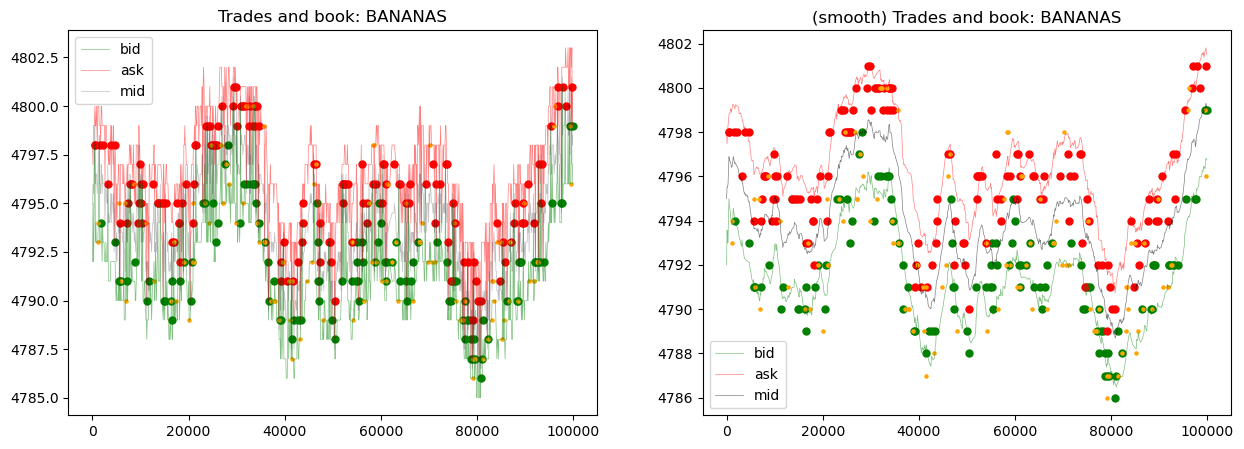

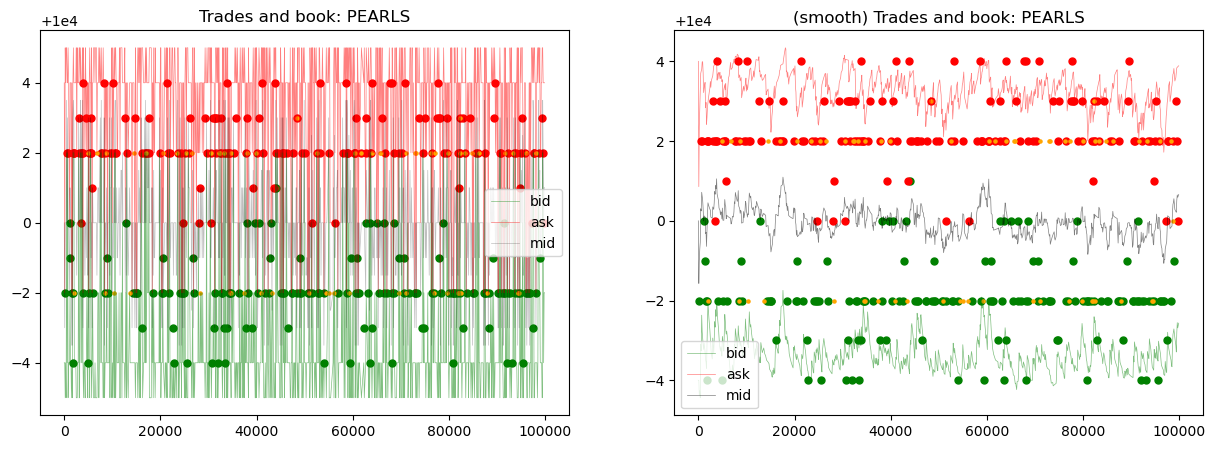

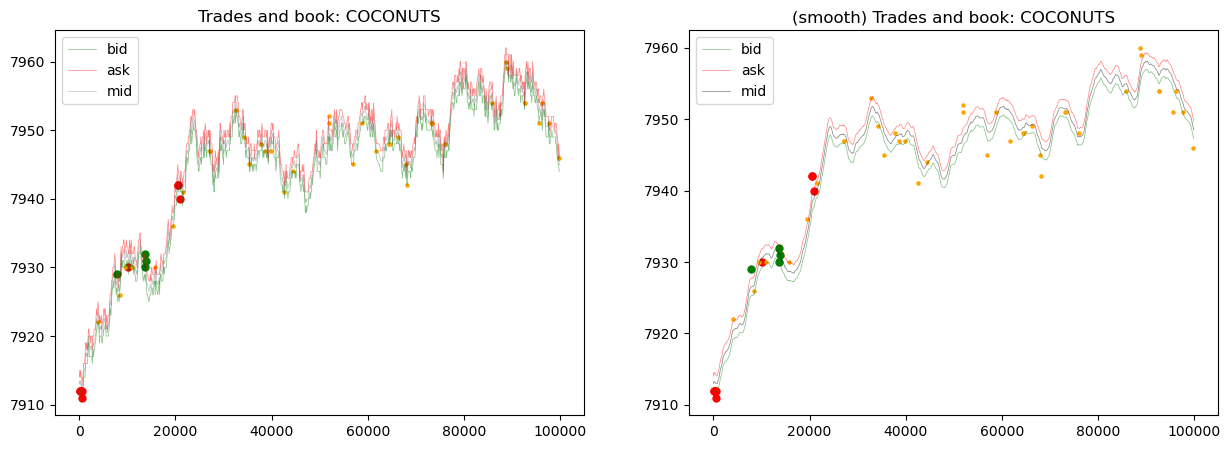

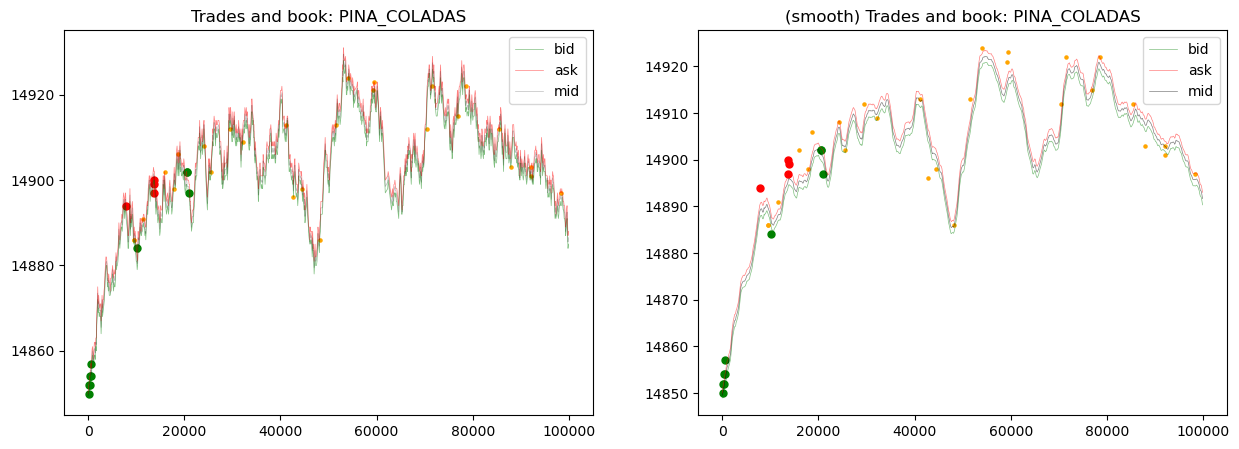

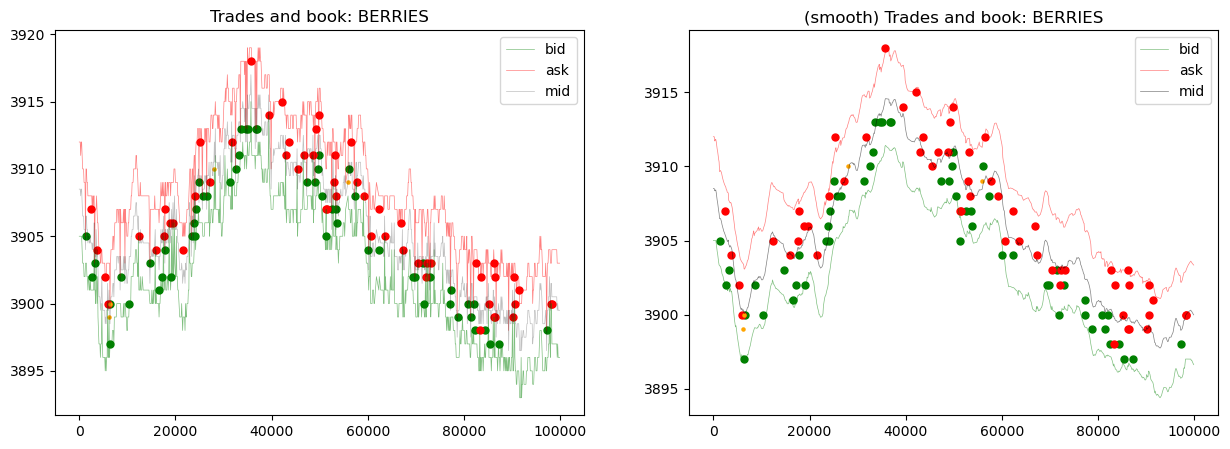

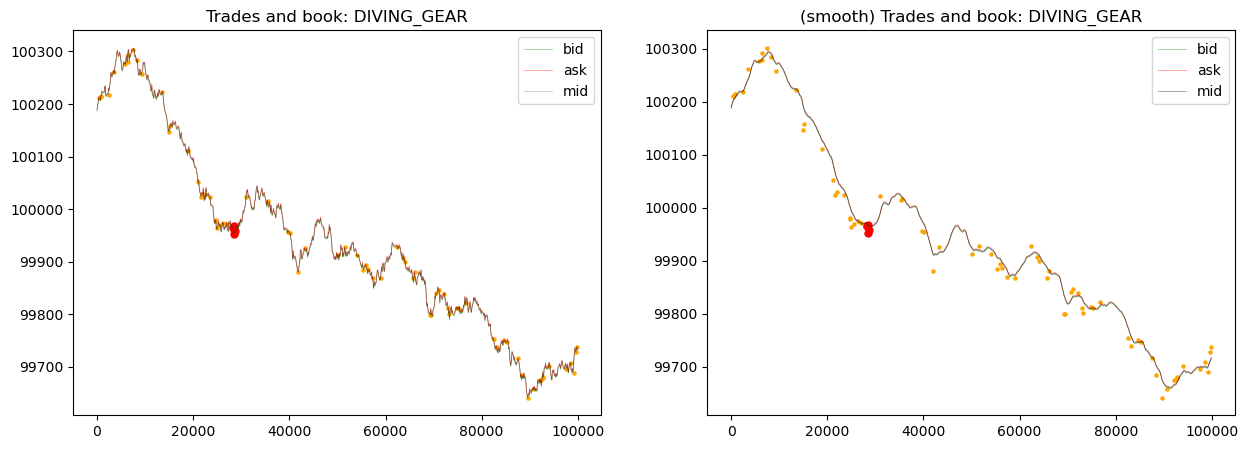

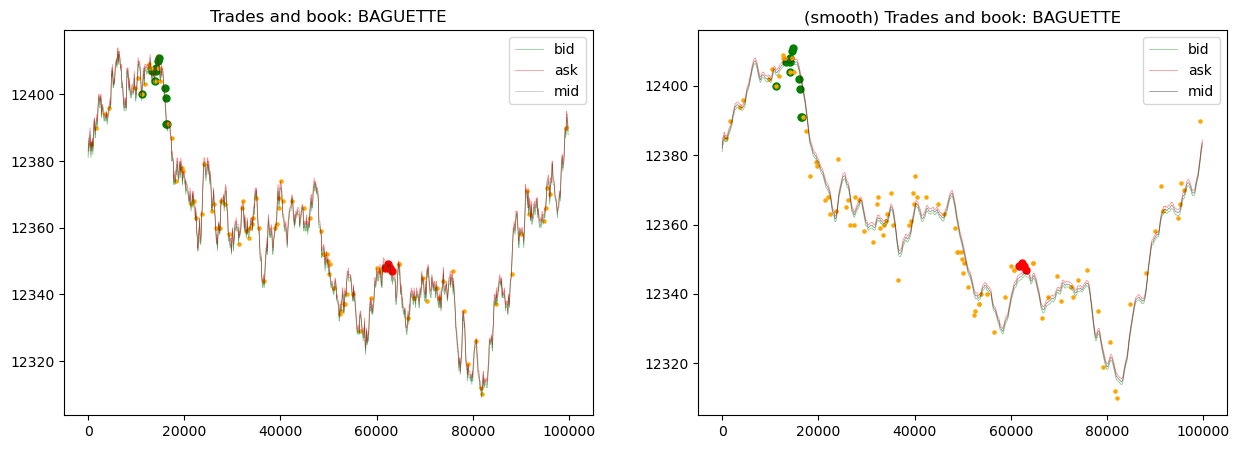

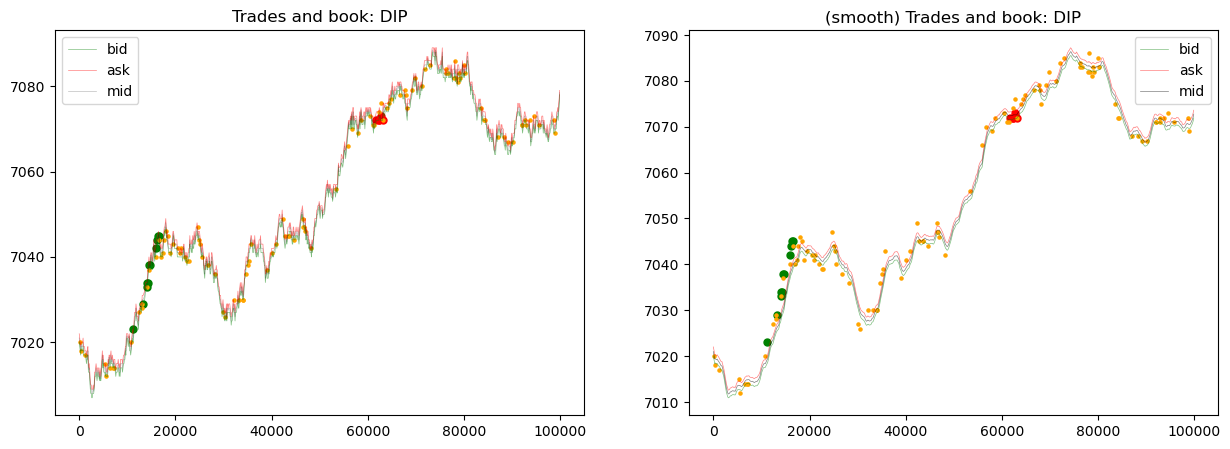

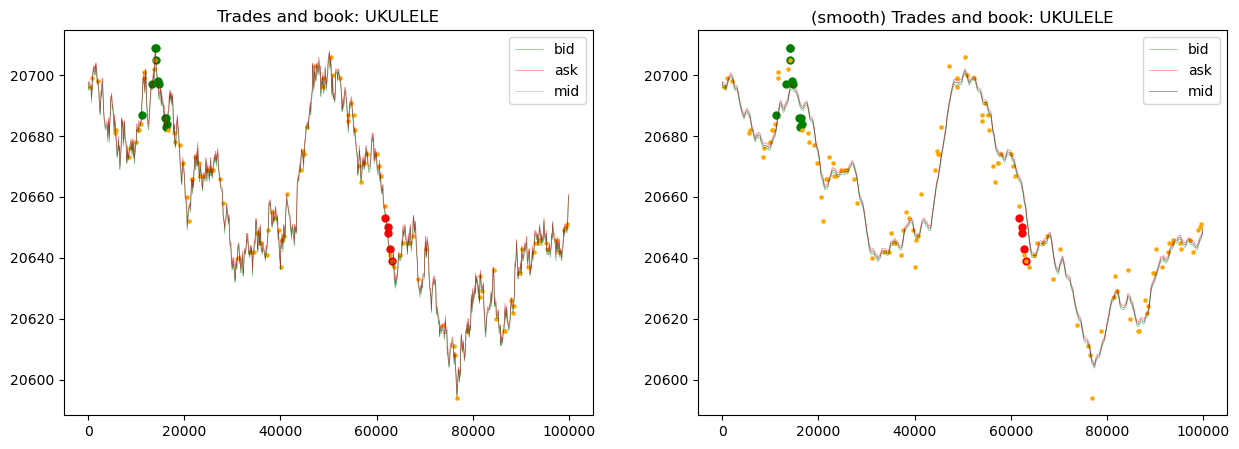

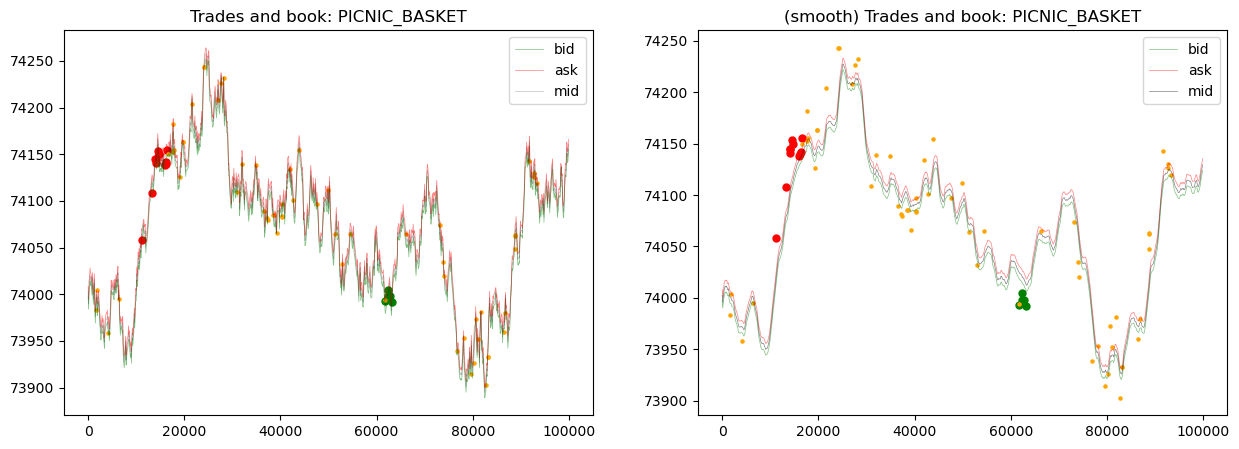

In [34]:
for sym in _symbols:
    plot_trades_and_book(
        sym=sym, 
        trade_df=trade_df, 
        book_df=book_tops, 
    #     time_lb=0, 
    #     time_ub=50000, 
        span=21,
        show_mid=True,
    )

### PNL Graph

Text(0.5, 1.0, 'PNL')

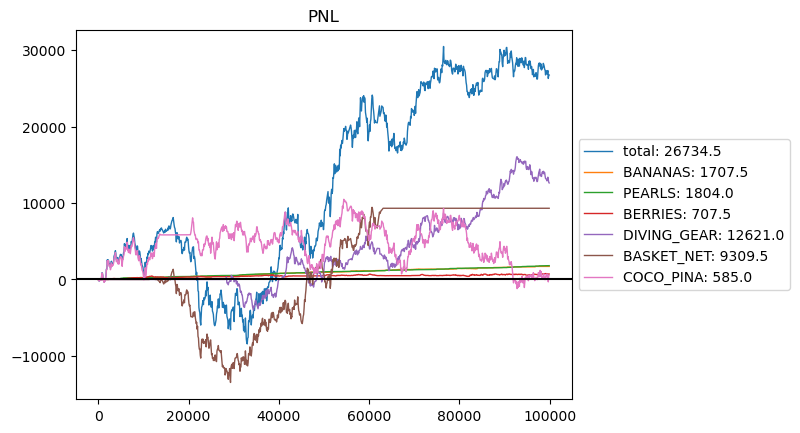

In [35]:
# pnl

# calc pnl from coco/pina pair
my_positions["COCO_PINA_pnl"] = my_positions["COCONUTS_pnl"] + my_positions["PINA_COLADAS_pnl"]

my_positions["BASKET_COMP_pnl"] = my_positions["BAGUETTE_pnl"] + my_positions["DIP_pnl"] + my_positions["UKULELE_pnl"]

my_positions["BASKET_NET_pnl"] = my_positions["BASKET_COMP_pnl"] + my_positions["PICNIC_BASKET_pnl"]

## shown products

# products_shown = ["BERRIES", "DIVING_GEAR"]
# products_shown = ["BAGUETTE", "DIP", "UKULELE", "BASKET_COMP", "PICNIC_BASKET", "BASKET_NET"]
products_shown = ["total", *_products]

### basket trade
for prod in ["DIP", "BAGUETTE", "UKULELE", "PICNIC_BASKET"]:
    products_shown.remove(prod)
# products_shown += ["BASKET_COMP"]
products_shown += ["BASKET_NET"]
    
### pina/coco section
products_shown.remove("COCONUTS")
products_shown.remove("PINA_COLADAS")
products_shown += ["COCO_PINA"]


for prod in products_shown:
    pnl = my_positions[f"{prod}_pnl"].iloc[-1]
    plt.plot(my_positions["time"], my_positions[f"{prod}_pnl"], label=f"{prod}: {pnl}", linewidth=1)

plt.axhline(y=0, color="black")
    
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.title(f"PNL")


### Positions Graph

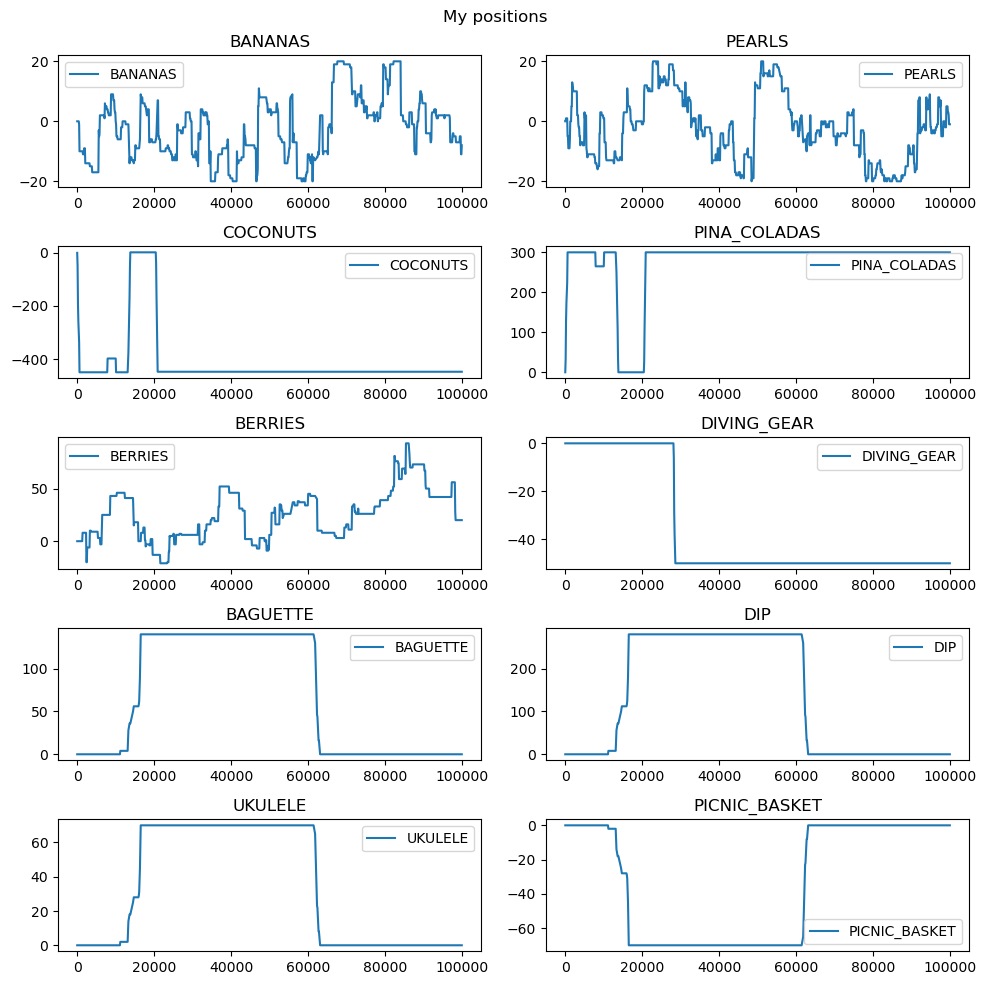

In [36]:
# plot my positions in each product

plt.figure(figsize=(10, 10))

for sym_i, sym in enumerate(_symbols):
    plt.subplot(5, 2, sym_i+1)
    plt.plot(my_positions["time"], my_positions[sym], label=sym)
    plt.title(sym)
    plt.legend()
    
    
plt.suptitle("My positions")
plt.tight_layout()
plt.show()

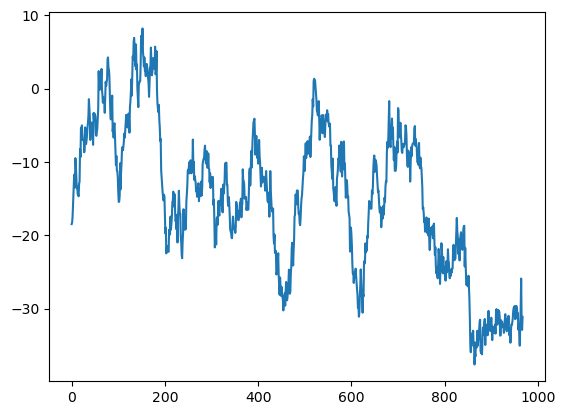

In [37]:
# plot pina_error (pina_actual - pina_pred)
model = np.poly1d([1.55131931e+00, 2.59237689e+03])

mid_df = book_tops[["COCONUTS_mid", "PINA_COLADAS_mid"]].copy()
mid_df["pred"] = model(mid_df["COCONUTS_mid"])
mid_df["pred_error"] = mid_df["PINA_COLADAS_mid"] - mid_df["pred"]

plt.plot(mid_df["pred_error"])
plt.show()

### Pina-coco error plot

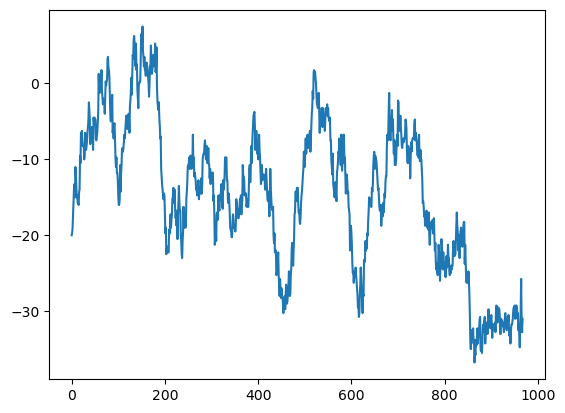

In [38]:
# plot pina_error (pina_actual - pina_pred)
model = np.poly1d([1.5, 3000])

mid_df = book_tops[["COCONUTS_mid", "PINA_COLADAS_mid"]].copy()
mid_df["pred"] = model(mid_df["COCONUTS_mid"])
mid_df["pred_error"] = mid_df["PINA_COLADAS_mid"] - mid_df["pred"]

plt.plot(mid_df["pred_error"])
plt.show()

In [39]:
# pina-coco exposures
diffs = my_positions["PINA_COLADAS"] + my_positions["COCONUTS"] * 1.5
diffs.describe().to_frame().T

,count,mean,std,min,25%,50%,75%,max
0,968.0,-345.207128,94.315677,-375.0,-372.0,-372.0,-372.0,3.0


(array([874.,  23.,   1.,   1.,   1.,   1.,   2.,   0.,   2.,  63.]),
 array([-375. , -337.2, -299.4, -261.6, -223.8, -186. , -148.2, -110.4,
         -72.6,  -34.8,    3. ]),
 <BarContainer object of 10 artists>)

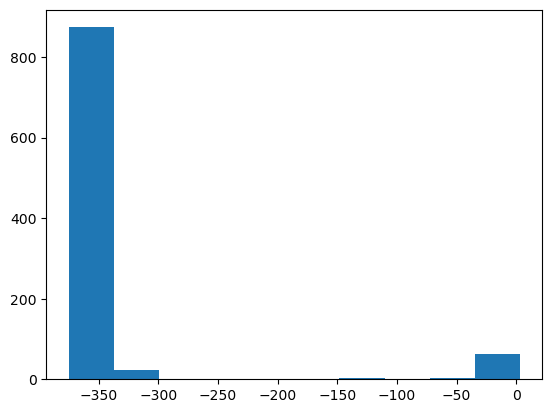

In [40]:
plt.hist(diffs)

In [41]:
my_positions[["PINA_COLADAS", "COCONUTS"]]

,PINA_COLADAS,COCONUTS
0,0.0,0.0
1,33.0,-49.0
2,128.0,-192.0
3,173.0,-259.0
4,198.0,-297.0
...,...,...
963,300.0,-448.0
964,300.0,-448.0
965,300.0,-448.0
966,300.0,-448.0


### Price movements (actual change)

,count,mean,std,min,25%,50%,75%,max
BANANAS_mid,967.0,0.003619,1.647741,-5.0,-1.00,0.0,1.0,6.0
PEARLS_mid,967.0,0.001034,2.251753,-6.5,-1.25,0.0,1.5,7.0
COCONUTS_mid,967.0,0.033092,0.939385,-3.5,-0.50,0.0,0.5,3.0
PINA_COLADAS_mid,967.0,0.038263,2.185162,-10.0,-1.50,0.0,1.5,6.0
BERRIES_mid,967.0,-0.009307,1.053888,-4.0,-0.50,0.0,0.5,3.5
DIVING_GEAR_mid,967.0,-0.470527,6.601447,-27.5,-5.00,-0.5,4.0,20.0
BAGUETTE_mid,967.0,0.007239,2.387630,-10.0,-1.50,0.0,1.5,7.5
DIP_mid,967.0,0.059462,1.149683,-4.0,-0.50,0.0,1.0,6.0
UKULELE_mid,967.0,-0.038263,2.919749,-9.0,-2.00,0.0,2.0,9.0
PICNIC_BASKET_mid,967.0,0.163392,10.989864,-43.0,-6.50,0.5,7.5,33.0


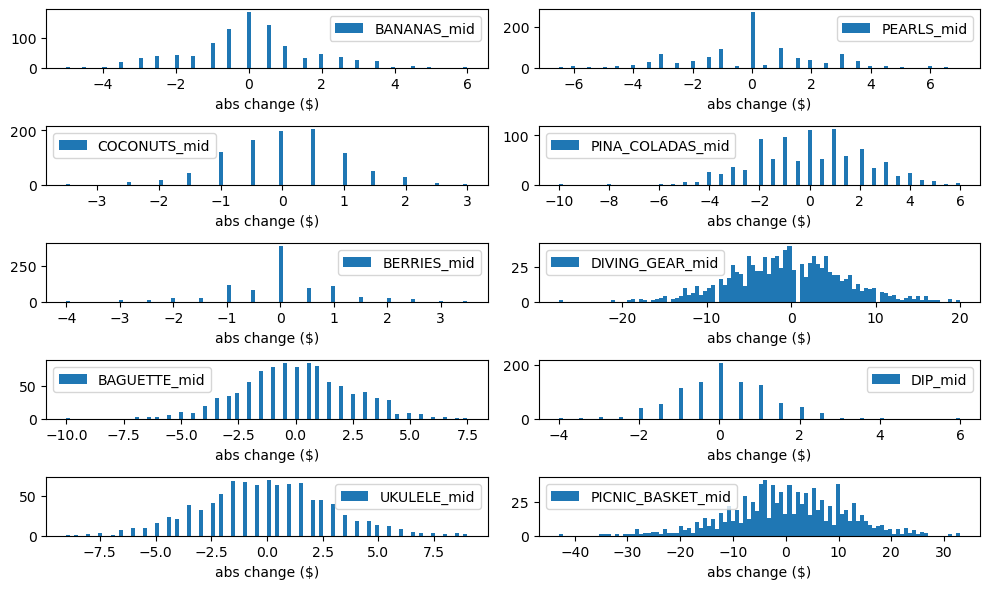

In [42]:
# distribution of price movements (pct change)

plt.figure(figsize=(10, 6))

mids = [f"{sym}_mid" for sym in _symbols]
cols = book_tops[mids]
diffs = (cols.shift(-1) - cols).dropna()

# show diffs stats
display(diffs.describe().T)


for sym_i, sym in enumerate(_symbols):
    
    mid = mids[sym_i]
    
    plt.subplot(5, 2, sym_i+1)

    plt.hist(diffs[mid], bins=100, label=mid)
    plt.xlabel("abs change ($)")
    plt.legend()
    
plt.tight_layout()
plt.show()


### Spread stats

BANANAS


,count,mean,std,min,25%,50%,75%,max
0,968.0,5.120868,1.897819,1.0,4.0,6.0,6.0,7.0


PEARLS


,count,mean,std,min,25%,50%,75%,max
0,968.0,6.634298,2.581163,2.0,6.0,7.0,8.0,10.0


COCONUTS


,count,mean,std,min,25%,50%,75%,max
0,968.0,2.445248,0.621153,1.0,2.0,3.0,3.0,3.0


PINA_COLADAS


,count,mean,std,min,25%,50%,75%,max
0,968.0,2.626033,0.61574,1.0,2.0,3.0,3.0,3.0


BERRIES


,count,mean,std,min,25%,50%,75%,max
0,968.0,6.47624,1.223458,2.0,7.0,7.0,7.0,7.0


DIVING_GEAR


,count,mean,std,min,25%,50%,75%,max
0,968.0,2.475207,0.537531,1.0,2.0,2.0,3.0,3.0


BAGUETTE


,count,mean,std,min,25%,50%,75%,max
0,968.0,1.60124,0.489896,1.0,1.0,2.0,2.0,2.0


DIP


,count,mean,std,min,25%,50%,75%,max
0,968.0,1.67562,0.468385,1.0,1.0,2.0,2.0,2.0


UKULELE


,count,mean,std,min,25%,50%,75%,max
0,968.0,1.423554,0.494377,1.0,1.0,1.0,2.0,2.0


PICNIC_BASKET


,count,mean,std,min,25%,50%,75%,max
0,968.0,11.393595,2.474072,1.0,11.0,12.0,13.0,14.0


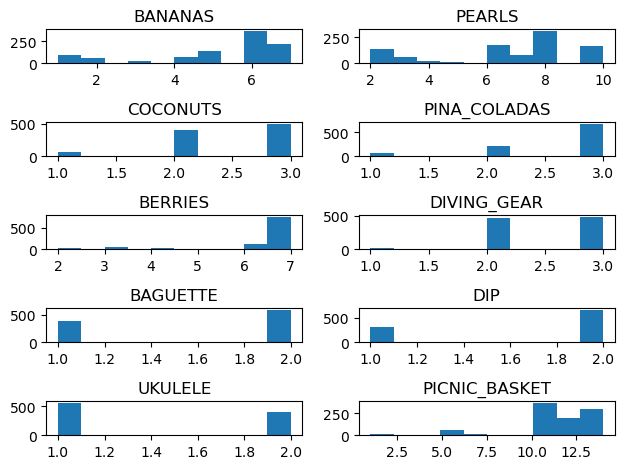

In [43]:
# spread summary stats

for sym_i, sym in enumerate(_symbols):
    print(sym)

    spreads = pd.DataFrame(book_tops[f"{sym}_best_sell"] - book_tops[f"{sym}_best_buy"])
    
    plt.subplot(5, 2, sym_i+1)
    plt.hist(spreads)
    plt.title(sym)
    display(spreads.describe().T)
    
plt.tight_layout()
plt.show()

In [44]:
# quantity stats
for sym in _symbols:
    df = trade_df[trade_df["symbol"] == sym]
    
    print(sym)
    display(df.groupby("time")[["quantity"]].sum().describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99]).T)

BANANAS


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,319.0,3.178683,3.94491,1.0,1.0,1.0,1.0,1.0,4.0,9.0,18.64,25.0


PEARLS


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,326.0,3.03681,2.872446,1.0,1.0,1.0,1.0,2.0,4.0,8.0,12.0,12.0


COCONUTS


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,53.0,38.886792,32.444426,1.0,3.08,7.0,9.0,39.0,52.0,72.6,133.12,143.0


PINA_COLADAS


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,41.0,23.073171,23.704842,2.0,2.0,2.0,3.0,21.0,33.0,45.0,90.2,95.0


BERRIES


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,115.0,7.904348,7.142625,0.0,1.0,1.0,3.0,5.0,10.5,18.0,29.0,30.0


DIVING_GEAR


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,77.0,2.324675,2.740733,1.0,1.0,1.0,1.0,2.0,2.0,3.0,12.36,23.0


BAGUETTE


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,108.0,5.787037,2.976704,2.0,2.0,3.0,4.0,5.0,7.0,8.3,15.72,24.0


DIP


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,119.0,7.596639,5.655834,3.0,3.0,4.0,5.0,6.0,9.0,10.0,32.82,48.0


UKULELE


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,125.0,3.496,2.431726,1.0,1.0,1.0,2.0,3.0,5.0,5.0,11.0,12.0


PICNIC_BASKET


,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max
quantity,74.0,2.608108,2.459633,1.0,1.0,1.0,1.0,2.0,3.0,6.0,10.54,12.0


In [45]:
book_tops

,BAGUETTE_best_buy,BAGUETTE_best_sell,BAGUETTE_mid,BAGUETTE_spread,BANANAS_best_buy,BANANAS_best_sell,BANANAS_mid,BANANAS_spread,BERRIES_best_buy,BERRIES_best_sell,...,PICNIC_BASKET_spread,PINA_COLADAS_best_buy,PINA_COLADAS_best_sell,PINA_COLADAS_mid,PINA_COLADAS_spread,UKULELE_best_buy,UKULELE_best_sell,UKULELE_mid,UKULELE_spread,time
turn,,,,,,,,,,,,,,,,,,,,,
0,12381.0,12383.0,12382.0,2.0,4792.0,4798.0,4795.0,6.0,3905.0,3912.0,...,11.0,14849.0,14850.0,14849.5,1.0,20697.0,20698.0,20697.5,1.0,0
1,12385.0,12387.0,12386.0,2.0,4795.0,4797.0,4796.0,2.0,3905.0,3912.0,...,11.0,14849.0,14852.0,14850.5,3.0,20695.0,20697.0,20696.0,2.0,100
2,12383.0,12385.0,12384.0,2.0,4792.0,4799.0,4795.5,7.0,3905.0,3912.0,...,14.0,14849.0,14852.0,14850.5,3.0,20696.0,20697.0,20696.5,1.0,200
3,12385.0,12387.0,12386.0,2.0,4793.0,4799.0,4796.0,6.0,3905.0,3911.0,...,12.0,14852.0,14854.0,14853.0,2.0,20696.0,20698.0,20697.0,2.0,300
4,12388.0,12390.0,12389.0,2.0,4798.0,4799.0,4798.5,1.0,3905.0,3912.0,...,14.0,14852.0,14854.0,14853.0,2.0,20696.0,20697.0,20696.5,1.0,400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
963,12393.0,12395.0,12394.0,2.0,4796.0,4803.0,4799.5,7.0,3897.0,3903.0,...,13.0,14890.0,14893.0,14891.5,3.0,20649.0,20650.0,20649.5,1.0,99500
964,12392.0,12394.0,12393.0,2.0,4801.0,4802.0,4801.5,1.0,3896.0,3903.0,...,11.0,14891.0,14894.0,14892.5,3.0,20648.0,20650.0,20649.0,2.0,99600
965,12392.0,12394.0,12393.0,2.0,4797.0,4803.0,4800.0,6.0,3896.0,3903.0,...,12.0,14887.0,14890.0,14888.5,3.0,20650.0,20651.0,20650.5,1.0,99700


In [46]:
book_top_df = book_tops.melt(id_vars=["time"])

merge = lambda x : ("_".join(x[0:2]), x[2])
cols = book_top_df["variable"].apply(lambda x : x.split("_", 1) if (x.split("_", 1)[0] in _symbols) else merge(x.split("_", 2)))
cols = cols.apply(pd.Series).set_axis(["symbol", "variable"], axis=1)

book_top_df = book_top_df.drop("variable", axis=1).join(cols)


###  taker vs maker stats

In [47]:
# merge current trades with previous turn's tops
my_trade_df = my_trades.copy()
my_trade_df["time"] -= _time_step

# get col to merge on
my_trade_df["variable"] = np.where(
    my_trade_df["my_buy"], 
    "best_sell", 
    "best_buy", 
)


my_trade_df = my_trade_df.merge(book_top_df, on=["time", "symbol", "variable"])


my_trade_df

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade,fair_value,buy_edge,variable,value
0,,7912.0,49,SUBMISSION,COCONUTS,0,0,1,True,False,True,-49,False,7912.5,0.5,best_buy,7912.0
1,SUBMISSION,14850.0,33,,PINA_COLADAS,0,0,1,True,True,False,33,False,14850.0,0.0,best_sell,14850.0
2,,7912.0,143,SUBMISSION,COCONUTS,100,100,2,True,False,True,-143,False,7913.5,1.5,best_buy,7912.0
3,SUBMISSION,9998.0,1,,PEARLS,100,100,2,True,True,False,1,False,10000.0,2.0,best_sell,9998.0
4,SUBMISSION,14852.0,95,,PINA_COLADAS,100,100,2,True,True,False,95,False,14850.5,-1.5,best_sell,14852.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
705,SUBMISSION,4799.0,2,,BANANAS,99300,99300,962,True,True,False,2,False,4799.0,0.0,best_sell,4799.0
706,,10002.0,1,SUBMISSION,PEARLS,99500,99500,964,True,False,True,-1,False,10000.0,-2.0,best_buy,10002.0
707,,10000.0,3,SUBMISSION,PEARLS,99600,99600,965,True,False,True,-3,False,10000.0,0.0,best_buy,10000.0
708,,4801.0,6,SUBMISSION,BANANAS,99600,99600,965,True,False,True,-6,False,4799.5,-1.5,best_buy,4801.0


In [48]:
# merge current trades with previous turn's tops
my_trade_df = my_trades.copy()
my_trade_df["time"] -= _time_step

# get col to merge on
my_trade_df["variable"] = np.where(
    my_trade_df["my_buy"], 
    "best_sell", 
    "best_buy", 
)


my_trade_df = my_trade_df.merge(book_top_df, on=["time", "symbol", "variable"])

# if my buy price is greater than best sell price
# if my sell price is less than best buy price
my_trade_df["is_take"] = np.where(
    my_trade_df["my_buy"],
    my_trade_df["price"] >= my_trade_df["value"], # 
    my_trade_df["price"] <= my_trade_df["value"], # 
)


In [49]:
my_trades

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade,fair_value,buy_edge
0,,7912.0,49,SUBMISSION,COCONUTS,0,100,1,True,False,True,-49,False,7912.5,0.5
2,SUBMISSION,14850.0,33,,PINA_COLADAS,0,100,1,True,True,False,33,False,14850.0,0.0
3,,7912.0,143,SUBMISSION,COCONUTS,100,200,2,True,False,True,-143,False,7913.5,1.5
4,SUBMISSION,9998.0,1,,PEARLS,100,200,2,True,True,False,1,False,10000.0,2.0
5,SUBMISSION,14852.0,95,,PINA_COLADAS,100,200,2,True,True,False,95,False,14850.5,-1.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,SUBMISSION,4799.0,2,,BANANAS,99300,99400,962,True,True,False,2,False,4799.0,0.0
1456,,10002.0,1,SUBMISSION,PEARLS,99500,99600,964,True,False,True,-1,False,10000.0,-2.0
1459,,10000.0,3,SUBMISSION,PEARLS,99600,99700,965,True,False,True,-3,False,10000.0,0.0
1455,,4801.0,6,SUBMISSION,BANANAS,99600,99700,965,True,False,True,-6,False,4799.5,-1.5


BANANAS - my TAKER pnl: 588.5


,count,mean,std,min,25%,50%,75%,max
my_edge,163.0,1.628834,0.865293,-1.0,1.5,1.5,2.5,2.5


BANANAS - my MAKER pnl: 787.5


,count,mean,std,min,25%,50%,75%,max
my_edge,84.0,1.952381,0.628725,-0.5,1.5,2.0,2.5,2.5


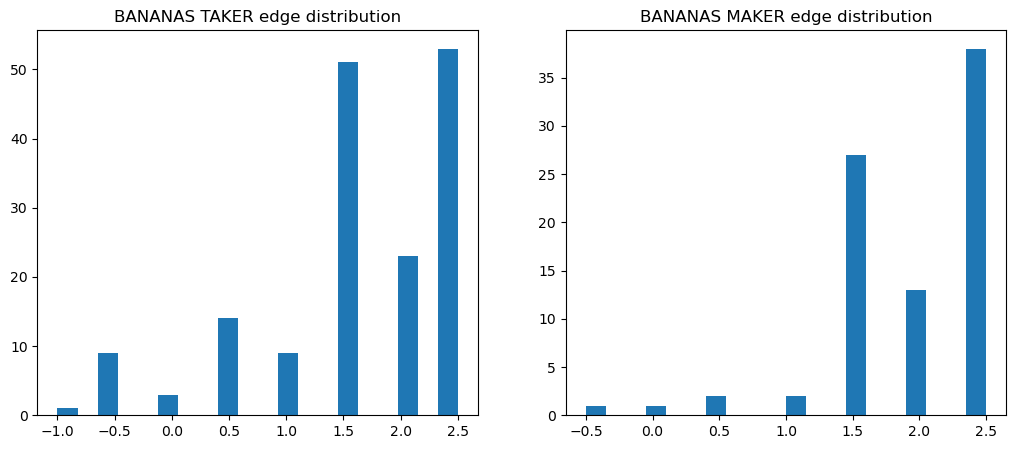

PEARLS - my TAKER pnl: 928.0


,count,mean,std,min,25%,50%,75%,max
my_edge,205.0,1.795122,0.607934,-0.0,2.0,2.0,2.0,2.0


PEARLS - my MAKER pnl: 860.0


,count,mean,std,min,25%,50%,75%,max
my_edge,95.0,2.873684,1.132143,-1.0,3.0,3.0,4.0,4.0


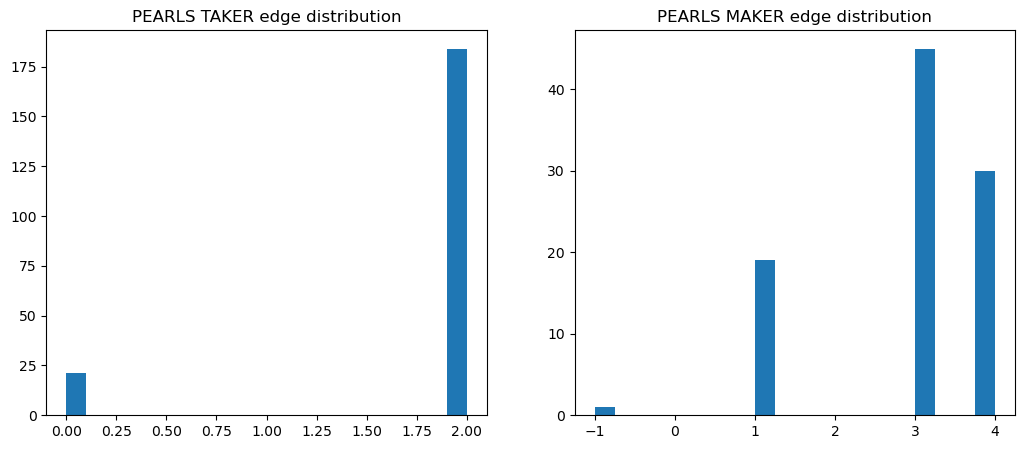

COCONUTS - my TAKER pnl: -1170.0


,count,mean,std,min,25%,50%,75%,max
my_edge,12.0,-1.25,0.452267,-1.5,-1.5,-1.5,-1.25,-0.5


COCONUTS - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


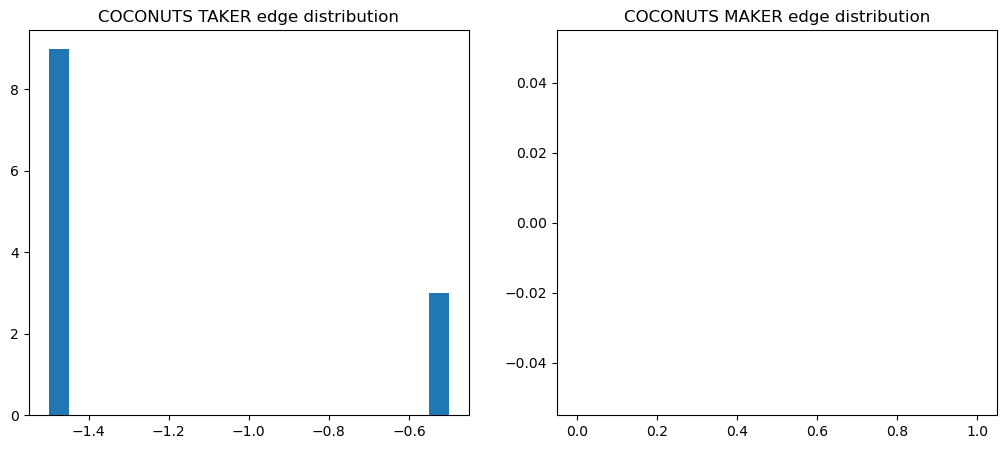

PINA_COLADAS - my TAKER pnl: -830.5


,count,mean,std,min,25%,50%,75%,max
my_edge,12.0,-1.291667,0.498102,-2.0,-1.5,-1.5,-1.0,0.0


PINA_COLADAS - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


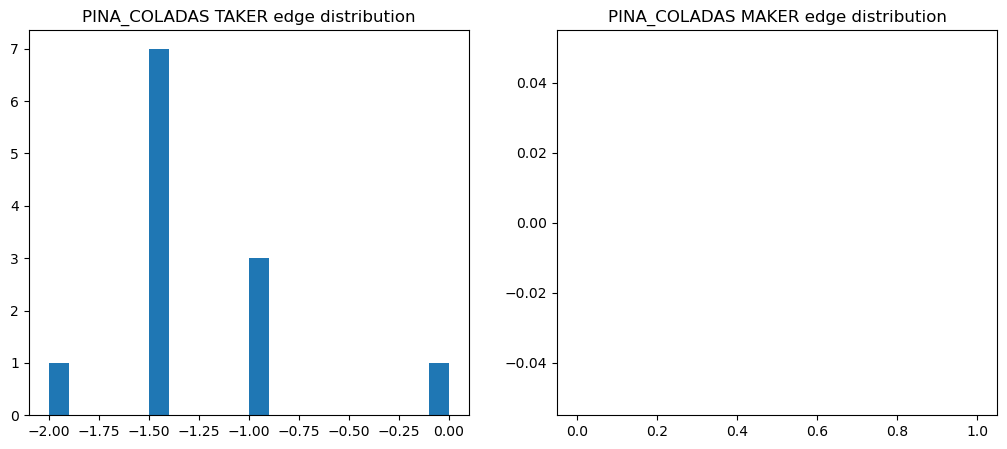

BERRIES - my TAKER pnl: 307.0


,count,mean,std,min,25%,50%,75%,max
my_edge,70.0,0.6,0.535683,-0.5,0.5,0.5,1.0,1.5


BERRIES - my MAKER pnl: 1029.5


,count,mean,std,min,25%,50%,75%,max
my_edge,40.0,2.4375,0.167466,2.0,2.5,2.5,2.5,2.5


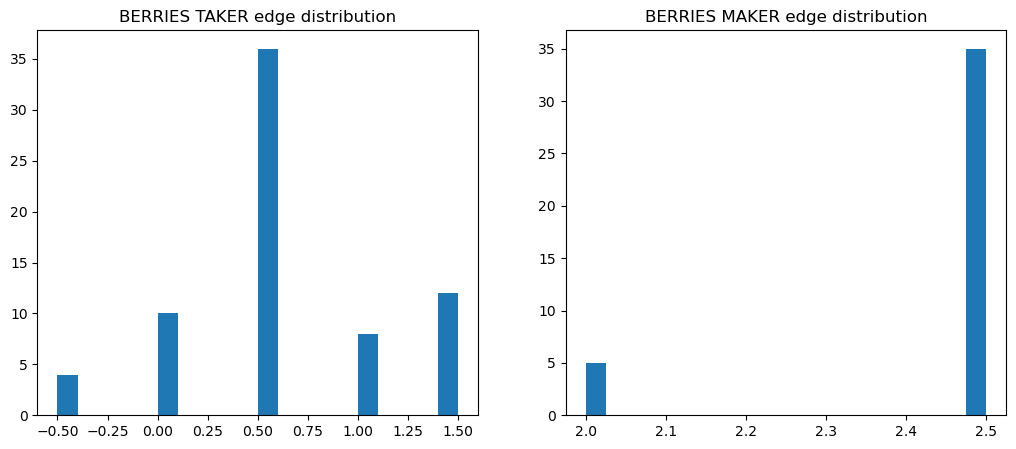

DIVING_GEAR - my TAKER pnl: -58.5


,count,mean,std,min,25%,50%,75%,max
my_edge,5.0,-1.0,0.353553,-1.5,-1.0,-1.0,-1.0,-0.5


DIVING_GEAR - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


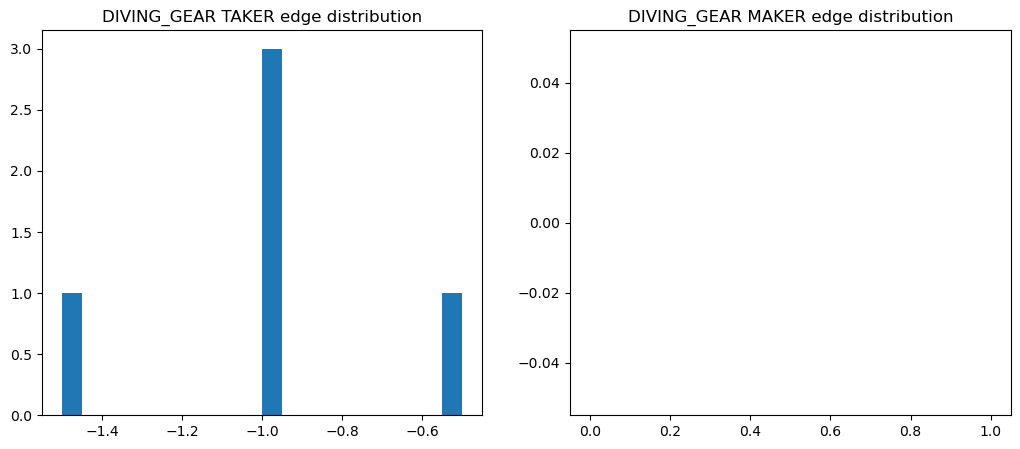

BAGUETTE - my TAKER pnl: -10.0


,count,mean,std,min,25%,50%,75%,max
my_edge,6.0,-0.666667,0.258199,-1.0,-0.875,-0.5,-0.5,-0.5


BAGUETTE - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


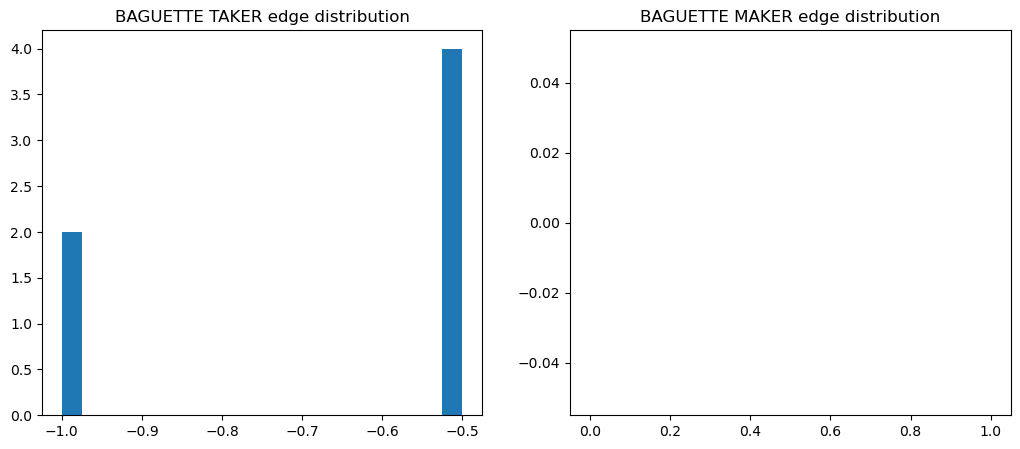

DIP - my TAKER pnl: -36.0


,count,mean,std,min,25%,50%,75%,max
my_edge,6.0,-1.083333,0.376386,-1.5,-1.375,-1.0,-1.0,-0.5


DIP - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


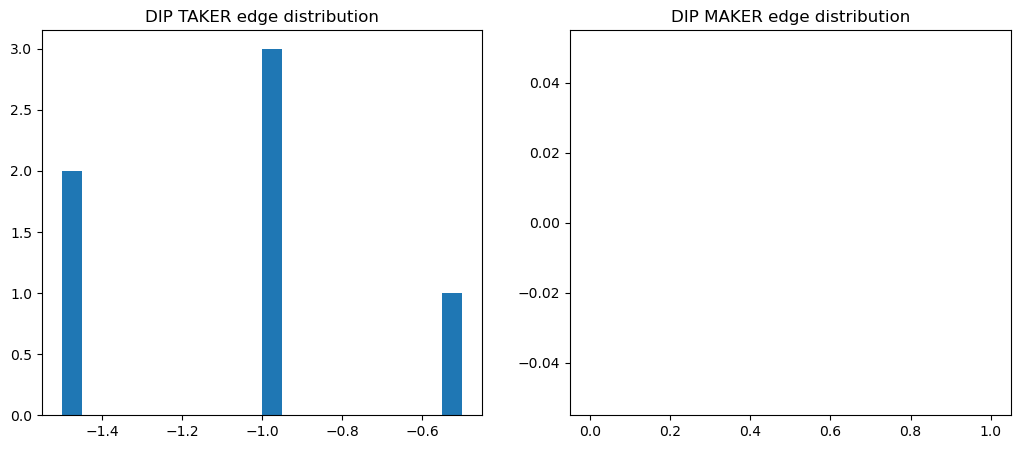

UKULELE - my TAKER pnl: -4.0


,count,mean,std,min,25%,50%,75%,max
my_edge,6.0,-0.333333,0.516398,-1.0,-0.75,0.0,0.0,-0.0


UKULELE - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


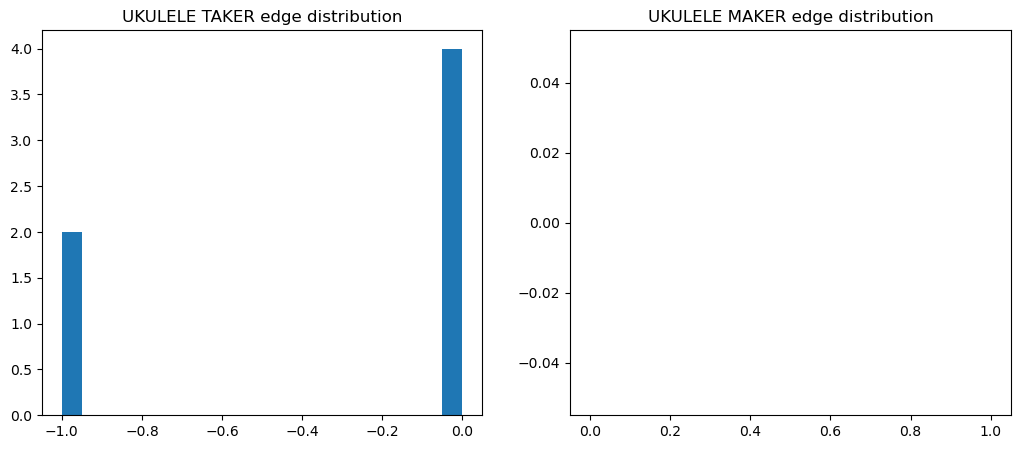

PICNIC_BASKET - my TAKER pnl: -44.5


,count,mean,std,min,25%,50%,75%,max
my_edge,6.0,-5.416667,0.491596,-6.0,-5.875,-5.25,-5.0,-5.0


PICNIC_BASKET - my MAKER pnl: 0.0


,count,mean,std,min,25%,50%,75%,max
my_edge,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


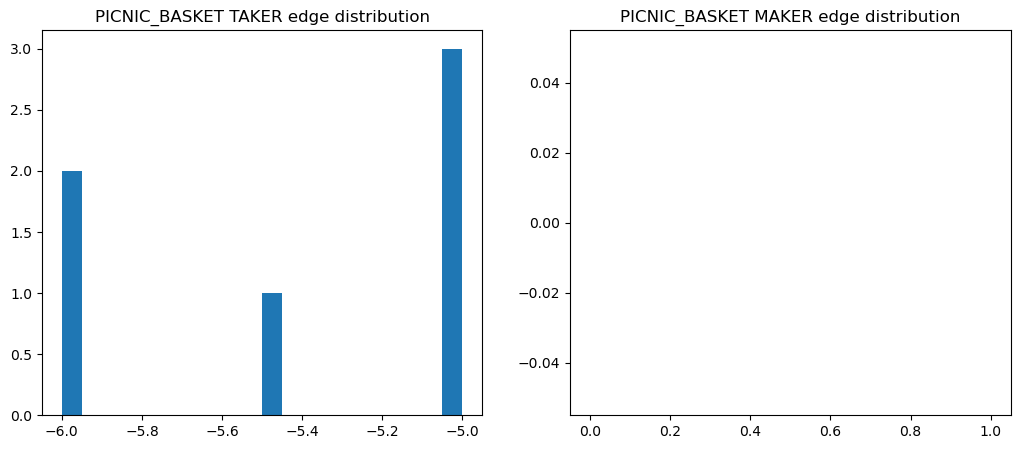

In [50]:
# merge current trades with previous turn's tops
my_trade_df = my_trades.copy()
my_trade_df["time"] -= _time_step

# get col to merge on
my_trade_df["variable"] = np.where(
    my_trade_df["my_buy"], 
    "best_sell", 
    "best_buy", 
)


my_trade_df = my_trade_df.merge(book_top_df, on=["time", "symbol", "variable"])

# if my buy price is greater than best sell price
# if my sell price is less than best buy price
my_trade_df["is_take"] = np.where(
    my_trade_df["my_buy"],
    my_trade_df["price"] >= my_trade_df["value"], # 
    my_trade_df["price"] <= my_trade_df["value"], # 
)


# drop cols
my_trade_df = my_trade_df.drop(["variable", "value"], axis=1)


# filter to keep only taker trades

# compute buy edge
my_trade_df["buy_edge"] = my_trade_df["fair_value"] - my_trade_df["price"]

# compute my edge
my_trade_df["my_edge"] = my_trade_df["buy_edge"] * np.sign(my_trade_df["my_quantity"])

# compute pnl
my_trade_df["pnl"] = my_trade_df["my_edge"] * my_trade_df["quantity"]

# filter by symbol
        
for sym in _symbols:
    the_df = my_trade_df[my_trade_df["symbol"] == sym]
    
    maker_df = the_df[~the_df["is_take"]]
    taker_df = the_df[the_df["is_take"]]
    

    # display pnl / stats for TAKER
    plt.figure(figsize=(12.5, 5))
    plt.subplot(121)
    print(sym, "- my TAKER pnl:", taker_df["pnl"].sum())

    display(taker_df[["my_edge"]].describe().T)

    plt.hist(taker_df[["my_edge"]], bins=20)
    plt.title(f"{sym} TAKER edge distribution")
    
    
    # display pnl / stats for MAKER
    plt.subplot(122)
    print(sym, "- my MAKER pnl:", maker_df["pnl"].sum())

    display(maker_df[["my_edge"]].describe().T)

    plt.hist(maker_df[["my_edge"]], bins=20)
    plt.title(f"{sym} MAKER edge distribution")
    plt.show()


In [51]:
my_trades[(my_trades["symbol"] == "BERRIES") & (my_trades["time"] < 1e5)]

,buyer,price,quantity,seller,symbol,order_time,time,turn,is_me,my_buy,my_sell,my_quantity,self_trade,fair_value,buy_edge
30,SUBMISSION,3905.0,8,,BERRIES,1300,1400,14,True,True,False,8,False,3906.5,1.5
45,,3907.0,28,SUBMISSION,BERRIES,2300,2400,24,True,False,True,-28,False,3905.0,-2.0
47,SUBMISSION,3902.0,14,,BERRIES,2500,2600,26,True,True,False,14,False,3904.5,2.5
51,SUBMISSION,3903.0,16,,BERRIES,3200,3300,33,True,True,False,16,False,3904.5,1.5
56,,3904.0,1,SUBMISSION,BERRIES,3500,3600,36,True,False,True,-1,False,3903.5,-0.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,,3900.0,3,SUBMISSION,BERRIES,90500,90600,874,True,False,True,-3,False,3899.5,-0.5
1341,,3901.0,8,SUBMISSION,BERRIES,91400,91500,883,True,False,True,-8,False,3898.5,-2.5
1424,SUBMISSION,3898.0,14,,BERRIES,97200,97300,941,True,True,False,14,False,3898.5,0.5
1435,,3900.0,28,SUBMISSION,BERRIES,98100,98200,950,True,False,True,-28,False,3899.5,-0.5


### taker/maker optimization


- deciding whether to take/make:
    - current inventory (estimated)
    - common
        - cur_pos
    - taker:
        - info:
            - edge, quantity
        - actions
            - take all/ignore
            - take up to quantity
        - transition
            - reward = edge * abs(taken_quantity)
            - new_pos = cur_pos + taken_quantity
    - maker:
        - info:
            - edge (the edge that we'd receive for placing an order at the best bid)
            - limit
        - actions
            - quantity up to limit
            
        - transition
            - randomized taken_quantity is selected
            - reward = edge * abs(taken_quantity)
            - new_pos = cur_pos + taken_quantity
- state:
    - current inventory (

In [52]:
def rollout_action(cur_pos, limit, act):
    """
    Performs action given cur_pospotential action `act`
    
    Returns new_pos, pnl_change
    """
    
    edge = act["edge"]
    quantity = act["quantity"]
    is_buy = act["is_buy"]

    if edge == 0:
        # only take if it's good for us
        if is_buy:
            quantity = min(quantity, 0 - cur_pos)
        else:
            quantity = min(quantity, 0 + cur_pos)
    else:
        # take maximum
        if is_buy:
            quantity = min(quantity, limit - cur_pos)
        else:
            quantity = min(quantity, limit + cur_pos)

    # update state
    pnl_change = quantity * edge
    quantity_change = quantity if is_buy else -1 * quantity

    return cur_pos + quantity_change, pnl_change



### monte-carlo sim
def rollout(cur_pdf, limit, action_df):
    """
    Runs one MC rollout using the specified params
    
    Returns pnl_per_turn, ending_position
    """
    
    all_pdf = {i: 0 for i in range(-limit, limit + 1)}
    all_pnl = 0
    
    for cur_pos, cur_pos_prob in cur_pdf.items():
        if cur_pos_prob == 0:
            continue

        
        pdf = {i: 0 for i in range(-limit, limit + 1)}
        # if we don't take any taker_df trades, we will remain in this position
        pdf[cur_pos] = 1 - action_df["freq"].sum()

        # trade_pnl will contain expected pnl from trading when we start at 'cur_pos'
        trade_pnl = 0

        # iterate through actions
        for index, row in action_df.iterrows():
            new_pos, pnl_diff = rollout_action(cur_pos, limit, row)

            # get pnl from trade
            trade_pnl += pnl_diff * row["freq"]
            pdf[new_pos] += row["freq"]
            
        # pnl contains total profits from edge up to this point
#         print("trade pnl", cur_pos, trade_pnl)
        
        # update all_pnl
        all_pnl += trade_pnl * cur_pos_prob
        
        # update all_pdf
        for next_pos, next_pos_prob in pdf.items():
            all_pdf[next_pos] += next_pos_prob * cur_pos_prob
            
    return all_pnl, all_pdf

In [53]:
# hyper-params
def get_markov_chain(sym, limit, rollout_length):

    num_turns = _max_time / _time_step

    # create taker_df
    taker_df = order_df[order_df["symbol"] == sym]
    taker_df = taker_df[taker_df["taker_edge"] >= 0]
    taker_df = taker_df[["quantity", "taker_edge"]].copy().rename({"taker_edge": "edge"}, axis=1)

    taker_df["is_buy"] = ~(taker_df["quantity"] > 0) # we can perform the opposite trade against this quantity
    taker_df["quantity"] = taker_df["quantity"].abs()
    taker_df["edge"] = taker_df["edge"].abs() # convert -0 to 0

    # create order_df
    the_df = my_trade_df[(my_trade_df["symbol"] == sym)]
    maker_df = the_df[~the_df["is_take"]]
    maker_df = maker_df[["quantity", "my_edge", "my_buy"]].rename({"my_buy": "is_buy", "my_edge": "edge"}, axis=1)

    # calculate pnl
    taker_df["pnl"] = taker_df["edge"] * taker_df["quantity"]
    maker_df["pnl"] = maker_df["edge"] * maker_df["quantity"]

    # print stats abt taker/maker

    print("taker chance", len(taker_df) / num_turns)
    print("maker chance", len(maker_df) / num_turns)
    print("market_trade chance", len(market_trades) / num_turns)

    # print taker profits

    print("Taker total edge by side")
    display(taker_df.groupby("is_buy")["pnl"].sum())

    print("Maker total edge by side")
    display(maker_df.groupby("is_buy")["pnl"].sum())



    # calculate taker stats
    taker_stats = taker_df.groupby(["quantity", "edge", "is_buy"]).value_counts().rename("freq").reset_index()
    taker_stats["freq"] /= num_turns

    maker_stats = maker_df.groupby(["quantity", "edge", "is_buy"]).value_counts().rename("freq").reset_index()
    maker_stats["freq"] /= num_turns

    print("len(taker_stats)", len(taker_stats))
    print("len(maker_stats)", len(maker_stats))


    ## calculate transition matrices
    trade_pnls = {}
    next_pdfs = {}

    for cur_pos in range(-limit, limit + 1):
        # setup initial cur_pdf
        cur_pdf = {i: 0 for i in range(-limit, limit + 1)}
        cur_pdf[cur_pos] = 1

        # rollout on taker
        taker_pnl, pdf1 = rollout(
            cur_pdf=cur_pdf,
            limit=limit,
            action_df=taker_stats,
        )

        # rollout on maker
        maker_pnl, pdf2 = rollout(
            cur_pdf=pdf1,
            limit=limit,
            action_df=maker_stats,
        )

        trade_pnls[cur_pos] = taker_pnl + maker_pnl
        next_pdfs[cur_pos] = pdf2

    # get A - transition probability matrix
    # a_ij is prob of going from j to i
    trans_prob_df = pd.DataFrame(next_pdfs)
    A = trans_prob_df.to_numpy()

    # each row should sum to 1
    assert np.all(abs(A.sum(axis=0) - 1) <= 1e-5)

    # get D - transition income matrix
    trans_pnl_df = pd.DataFrame(trade_pnls.items(), columns=["cur_pos", "pnl"])
    trans_pnl_df = trans_pnl_df.sort_values(by="cur_pos")

    D = trans_pnl_df["pnl"].to_numpy()

    return A, D

In [54]:
# calculate scores
def score_matrix(A, D, limit):
    scores = {}

    for cur_pos in range(-limit, limit + 1):
        # init cur_pdf
        cur_pdf = np.zeros((2 * limit + 1, 1))
        cur_pdf[cur_pos + limit, 0] = 1

        pnl = 0

        # iterate for rollout number of times
        for i in range(rollout_length):
            trade_pnl = np.dot(D, cur_pdf).item()
            cur_pdf = A @ cur_pdf

            pnl += trade_pnl

        scores[cur_pos] = pnl
        
    score_df = pd.DataFrame(scores.items(), columns=["start_pos", "pnl"])
    score_df = score_df.set_index("start_pos")
    score_df["pnl_diff"] = score_df["pnl"] - score_df["pnl"].loc[0]
    score_df["pnl_diff_rev"] = list(score_df["pnl_diff"].iloc[::-1])
    score_df["pnl_norm"] = (score_df["pnl_diff_rev"] + score_df["pnl_diff"]) / 2
    
    return score_df

taker chance 0.076
maker chance 0.0
market_trade chance 0.691
Taker total edge by side


is_buy
False    201.5
True     242.5
Name: pnl, dtype: float64

Maker total edge by side


Series([], Name: pnl, dtype: float64)

len(taker_stats) 39
len(maker_stats) 0


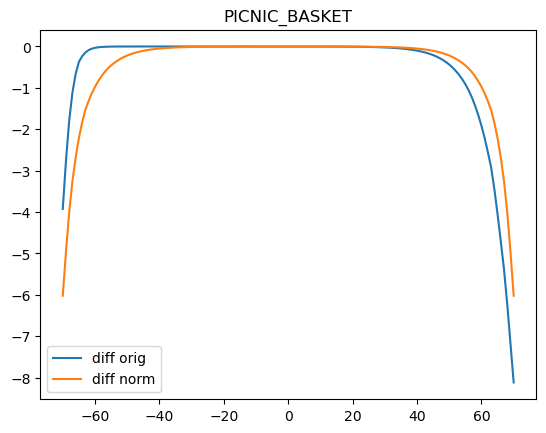

,pnl,pnl_diff,pnl_diff_rev,pnl_norm
start_pos,,,,
-70,440.071273,-3.923792,-8.115578,-6.019685
-69,441.240704,-2.754361,-7.158848,-4.956605
-68,442.209088,-1.785977,-6.225190,-4.005583
-67,442.880583,-1.114483,-5.385435,-3.249959
-66,443.331444,-0.663622,-4.705742,-2.684682
...,...,...,...,...
66,439.289323,-4.705742,-0.663622,-2.684682
67,438.609630,-5.385435,-1.114483,-3.249959
68,437.769876,-6.225190,-1.785977,-4.005583


,pnl,pnl_diff,pnl_diff_rev,pnl_norm
start_pos,,,,
-70,440.071273,-3.923792,-8.115578,-6.019685
-69,441.240704,-2.754361,-7.158848,-4.956605
-68,442.209088,-1.785977,-6.225190,-4.005583
-67,442.880583,-1.114483,-5.385435,-3.249959
-66,443.331444,-0.663622,-4.705742,-2.684682
...,...,...,...,...
66,439.289323,-4.705742,-0.663622,-2.684682
67,438.609630,-5.385435,-1.114483,-3.249959
68,437.769876,-6.225190,-1.785977,-4.005583


In [55]:
# show scores for each position
rollout_length = 1000
limit = 70
sym = "PICNIC_BASKET"

A, D = get_markov_chain(
    sym=sym,
    limit=limit,
    rollout_length=rollout_length,
)
score_df = score_matrix(A, D, limit=limit)

plt.plot(score_df.index, score_df["pnl_diff"], label="diff orig")
plt.plot(score_df.index, score_df["pnl_norm"], label="diff norm")
plt.legend()
plt.title(sym)
plt.show()

display(score_df)

# save to file
opp_costs = score_df["pnl_norm"].round(2).to_dict()
with open(f"./opp_costs_{sym}.json", "w") as f:
    f.write(str(opp_costs))

# save to file
opp_costs = score_df["pnl_diff"].round(2).to_dict()
with open(f"./opp_costs_nonsym_{sym}.json", "w") as f:
    f.write(str(opp_costs))
    
score_df

taker chance 0.074
maker chance 0.04
market_trade chance 0.691
Taker total edge by side


is_buy
False     79.0
True     285.0
Name: pnl, dtype: float64

Maker total edge by side


is_buy
False    505.0
True     524.5
Name: pnl, dtype: float64

len(taker_stats) 49
len(maker_stats) 24


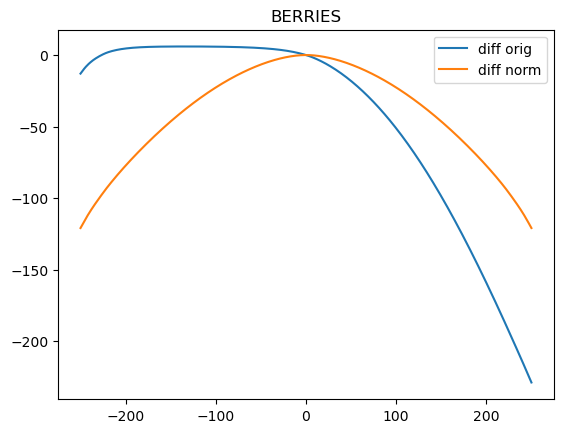

,pnl,pnl_diff,pnl_diff_rev,pnl_norm
start_pos,,,,
-250,1356.804572,-12.980903,-228.943497,-120.962200
-249,1357.655082,-12.130393,-227.530779,-119.830586
-248,1358.507176,-11.278300,-226.090300,-118.684300
-247,1359.357029,-10.428446,-224.634644,-117.531545
-246,1360.156426,-9.629049,-223.180226,-116.404638
...,...,...,...,...
246,1146.605249,-223.180226,-9.629049,-116.404638
247,1145.150831,-224.634644,-10.428446,-117.531545
248,1143.695175,-226.090300,-11.278300,-118.684300


,pnl,pnl_diff,pnl_diff_rev,pnl_norm
start_pos,,,,
-250,1356.804572,-12.980903,-228.943497,-120.962200
-249,1357.655082,-12.130393,-227.530779,-119.830586
-248,1358.507176,-11.278300,-226.090300,-118.684300
-247,1359.357029,-10.428446,-224.634644,-117.531545
-246,1360.156426,-9.629049,-223.180226,-116.404638
...,...,...,...,...
246,1146.605249,-223.180226,-9.629049,-116.404638
247,1145.150831,-224.634644,-10.428446,-117.531545
248,1143.695175,-226.090300,-11.278300,-118.684300


In [56]:
# show scores for each position
rollout_length = 1000
limit = 250
sym = "BERRIES"

A, D = get_markov_chain(
    sym=sym,
    limit=limit,
    rollout_length=rollout_length,
)
score_df = score_matrix(A, D, limit=limit)

plt.plot(score_df.index, score_df["pnl_diff"], label="diff orig")
plt.plot(score_df.index, score_df["pnl_norm"], label="diff norm")
plt.legend()
plt.title(sym)
plt.show()

display(score_df)

# save to file
opp_costs = score_df["pnl_norm"].round(2).to_dict()
with open(f"./opp_costs_{sym}.json", "w") as f:
    f.write(str(opp_costs))

# save to file
opp_costs = score_df["pnl_diff"].round(2).to_dict()
with open(f"./opp_costs_nonsym_{sym}.json", "w") as f:
    f.write(str(opp_costs))
    
score_df

taker chance 0.172
maker chance 0.084
market_trade chance 0.691
Taker total edge by side


is_buy
False    281.0
True     357.5
Name: pnl, dtype: float64

Maker total edge by side


is_buy
False    410.5
True     377.0
Name: pnl, dtype: float64

len(taker_stats) 53
len(maker_stats) 44


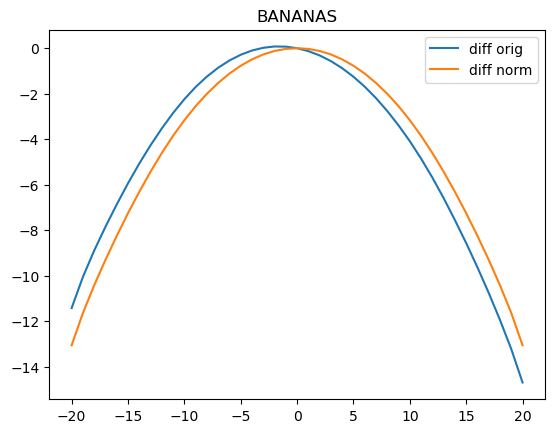

,pnl,pnl_diff,pnl_diff_rev,pnl_norm
start_pos,,,,
-20,1231.101897,-11.420319,-14.690042,-13.055180
-19,1232.471211,-10.051005,-13.223582,-11.637293
-18,1233.628066,-8.894150,-11.944811,-10.419480
-17,1234.674171,-7.848044,-10.755712,-9.301878
-16,1235.654639,-6.867577,-9.631520,-8.249548
-15,1236.585316,-5.936900,-8.564618,-7.250759
-14,1237.452605,-5.069611,-7.552181,-6.310896
-13,1238.255970,-4.266245,-6.587657,-5.426951
-12,1238.997586,-3.524630,-5.684988,-4.604809


,pnl,pnl_diff,pnl_diff_rev,pnl_norm
start_pos,,,,
-20,1231.101897,-11.420319,-14.690042,-13.055180
-19,1232.471211,-10.051005,-13.223582,-11.637293
-18,1233.628066,-8.894150,-11.944811,-10.419480
-17,1234.674171,-7.848044,-10.755712,-9.301878
-16,1235.654639,-6.867577,-9.631520,-8.249548
-15,1236.585316,-5.936900,-8.564618,-7.250759
-14,1237.452605,-5.069611,-7.552181,-6.310896
-13,1238.255970,-4.266245,-6.587657,-5.426951
-12,1238.997586,-3.524630,-5.684988,-4.604809


In [57]:
# show scores for each position
rollout_length = 1000
limit = 20
sym = "BANANAS"

A, D = get_markov_chain(
    sym=sym,
    limit=limit,
    rollout_length=rollout_length,
)
score_df = score_matrix(A, D, limit=limit)

plt.plot(score_df.index, score_df["pnl_diff"], label="diff orig")
plt.plot(score_df.index, score_df["pnl_norm"], label="diff norm")
plt.legend()
plt.title(sym)
plt.show()

display(score_df)

# save to file
opp_costs = score_df["pnl_norm"].round(2).to_dict()
with open(f"./opp_costs_{sym}.json", "w") as f:
    f.write(str(opp_costs))

# save to file
opp_costs = score_df["pnl_diff"].round(2).to_dict()
with open(f"./opp_costs_nonsym_{sym}.json", "w") as f:
    f.write(str(opp_costs))
    
score_df

taker chance 0.237
maker chance 0.095
market_trade chance 0.691
Taker total edge by side


is_buy
False    450.0
True     490.0
Name: pnl, dtype: float64

Maker total edge by side


is_buy
False    483.0
True     377.0
Name: pnl, dtype: float64

len(taker_stats) 33
len(maker_stats) 36


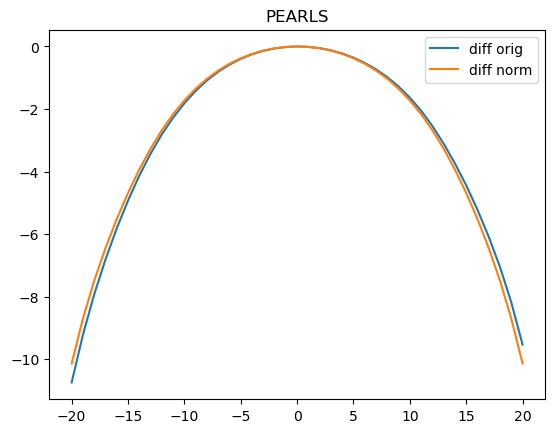

,pnl,pnl_diff,pnl_diff_rev,pnl_norm
start_pos,,,,
-20,1719.243055,-10.745114,-9.533990,-10.139552
-19,1720.764792,-9.223377,-8.181039,-8.702208
-18,1722.058717,-7.929452,-7.053562,-7.491507
-17,1723.172975,-6.815194,-6.085424,-6.450309
-16,1724.168876,-5.819293,-5.221352,-5.520323
-15,1725.057610,-4.930559,-4.437626,-4.684093
-14,1725.855270,-4.132898,-3.738258,-3.935578
-13,1726.559822,-3.428346,-3.107558,-3.267952
-12,1727.177776,-2.810393,-2.542218,-2.676305


,pnl,pnl_diff,pnl_diff_rev,pnl_norm
start_pos,,,,
-20,1719.243055,-10.745114,-9.533990,-10.139552
-19,1720.764792,-9.223377,-8.181039,-8.702208
-18,1722.058717,-7.929452,-7.053562,-7.491507
-17,1723.172975,-6.815194,-6.085424,-6.450309
-16,1724.168876,-5.819293,-5.221352,-5.520323
-15,1725.057610,-4.930559,-4.437626,-4.684093
-14,1725.855270,-4.132898,-3.738258,-3.935578
-13,1726.559822,-3.428346,-3.107558,-3.267952
-12,1727.177776,-2.810393,-2.542218,-2.676305


In [58]:
# show scores for each position
rollout_length = 1000
limit = 20
sym = "PEARLS"

A, D = get_markov_chain(
    sym=sym,
    limit=limit,
    rollout_length=rollout_length,
)
score_df = score_matrix(A, D, limit=limit)

plt.plot(score_df.index, score_df["pnl_diff"], label="diff orig")
plt.plot(score_df.index, score_df["pnl_norm"], label="diff norm")
plt.legend()
plt.title(sym)
plt.show()

display(score_df)

# save to file
opp_costs = score_df["pnl_norm"].round(2).to_dict()
with open(f"./opp_costs_{sym}.json", "w") as f:
    f.write(str(opp_costs))

# save to file
opp_costs = score_df["pnl_diff"].round(2).to_dict()
with open(f"./opp_costs_nonsym_{sym}.json", "w") as f:
    f.write(str(opp_costs))
    
score_df

### Available Taker edge

In [59]:
# calculate available taker edge

avail_taker_df = order_df[order_df["taker_edge"] > 0].copy()
avail_taker_df["pnl"] = avail_taker_df["taker_edge"] * avail_taker_df["quantity"].abs()

for sym in _symbols:
    df = avail_taker_df[avail_taker_df["symbol"] == sym]
    print(f"Available taker edge in {sym}", df["pnl"].sum().round())



Available taker edge in BANANAS 638.0
Available taker edge in PEARLS 940.0
Available taker edge in COCONUTS 1278.0
Available taker edge in PINA_COLADAS 664.0
Available taker edge in BERRIES 364.0
Available taker edge in DIVING_GEAR 12.0
Available taker edge in BAGUETTE 32.0
Available taker edge in DIP 8.0
Available taker edge in UKULELE 0.0
Available taker edge in PICNIC_BASKET 444.0


### missed takers


In [60]:

# get avail taker trades + my taker trades
avail_df = avail_taker_df
my_df = my_trade_df[my_trade_df["is_take"]]

# filter columns
my_df = my_df[["time", "symbol", "price", "my_quantity"]]
avail_df = avail_df[["time", "symbol", "price", "quantity", "taker_edge", "fair_value"]]

# see which avail taker trades were actually taken by me
taker_df = avail_df.merge(my_df, how="left", on=["time", "symbol", "price"])

taker_df["my_quantity"] = taker_df["my_quantity"].fillna(0)

# ensure my_quantity is not the same sign of resting order quantity
wrongs = (taker_df["my_quantity"] == taker_df["quantity"])
assert(wrongs.sum() == 0)
# display(taker_df[wrongs])

# calculate taken vs avail size
taker_df["avail_size"] = taker_df["quantity"].abs()
taker_df["taken_size"] = np.minimum(taker_df["my_quantity"].abs(), taker_df["avail_size"])
taker_df["missed_size"] = taker_df["avail_size"] - taker_df["taken_size"]

# calculate taken vs avail pnl
taker_df["avail_pnl"] = taker_df["taker_edge"] * taker_df["avail_size"]
taker_df["taken_pnl"] = taker_df["taker_edge"] * taker_df["taken_size"]
taker_df["missed_pnl"] = taker_df["taker_edge"] * taker_df["missed_size"]

for sym in _symbols:
    df = taker_df[taker_df["symbol"] == sym]
    
    print(sym, "taken_pnl", df["taken_pnl"].sum())
    print(sym, "avail_pnl", df["avail_pnl"].sum())
    print(sym, "missed_pnl", df["missed_pnl"].sum())
    print()
    print(sym, "taken_size", df["taken_size"].sum())
    print(sym, "avail_size", df["avail_size"].sum())
    print(sym, "missed_size", df["missed_size"].sum())
    print()


BANANAS taken_pnl 528.5
BANANAS avail_pnl 638.5
BANANAS missed_pnl 110.0

BANANAS taken_size 322.0
BANANAS avail_size 402
BANANAS missed_size 80.0

PEARLS taken_pnl 928.0
PEARLS avail_pnl 940.0
PEARLS missed_pnl 12.0

PEARLS taken_size 464.0
PEARLS avail_size 470
PEARLS missed_size 6.0

COCONUTS taken_pnl 0.0
COCONUTS avail_pnl 1278.5
COCONUTS missed_pnl 1278.5

COCONUTS taken_size 0.0
COCONUTS avail_size 2557
COCONUTS missed_size 2557.0

PINA_COLADAS taken_pnl 0.0
PINA_COLADAS avail_pnl 663.5
PINA_COLADAS missed_pnl 663.5

PINA_COLADAS taken_size 0.0
PINA_COLADAS avail_size 1200
PINA_COLADAS missed_size 1200.0

BERRIES taken_pnl 314.0
BERRIES avail_pnl 364.0
BERRIES missed_pnl 50.0

BERRIES taken_size 406.0
BERRIES avail_size 489
BERRIES missed_size 83.0

DIVING_GEAR taken_pnl 0.0
DIVING_GEAR avail_pnl 11.5
DIVING_GEAR missed_pnl 11.5

DIVING_GEAR taken_size 0.0
DIVING_GEAR avail_size 23
DIVING_GEAR missed_size 23.0

BAGUETTE taken_pnl 0.0
BAGUETTE avail_pnl 31.5
BAGUETTE missed_pnl 3

In [61]:
# missed takers
my_pos_df = my_positions.melt(id_vars=["time"], value_vars=_symbols, var_name="symbol", value_name="cur_pos")

untaken_df = taker_df[taker_df["avail_size"] != taker_df["taken_size"]]

# untaken_df = untaken_df[["time", "symbol", "price", "fair_value", "taker_edge", "avail_size", "taken_size"]].merge(my_pos_df, on=["time", "symbol"])
untaken_df = untaken_df.merge(my_pos_df, on=["time", "symbol"])

for sym in _symbols:
    df = untaken_df[untaken_df["symbol"] == sym].drop(["my_quantity"], axis=1)
    
    display(df)
    
    

,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
52,32800,BANANAS,4797,-6,0.5,4797.5,6,0.0,6.0,3.0,0.0,3.0,2.0
67,39600,BANANAS,4792,3,1.0,4791.0,3,0.0,3.0,3.0,0.0,3.0,-18.0
73,40700,BANANAS,4791,1,1.5,4789.5,1,0.0,1.0,1.5,0.0,1.5,-20.0
98,55400,BANANAS,4790,-1,2.5,4792.5,1,0.0,1.0,2.5,0.0,2.5,8.0
102,57500,BANANAS,4795,5,1.0,4794.0,5,0.0,5.0,5.0,0.0,5.0,-19.0
106,58900,BANANAS,4796,9,1.5,4794.5,9,1.0,8.0,13.5,1.5,12.0,-19.0
112,60200,BANANAS,4795,4,0.5,4794.5,4,1.0,3.0,2.0,0.5,1.5,-11.0
123,66900,BANANAS,4793,-5,0.5,4793.5,5,0.0,5.0,2.5,0.0,2.5,19.0
125,68100,BANANAS,4794,-1,2.5,4796.5,1,0.0,1.0,2.5,0.0,2.5,20.0
126,68400,BANANAS,4794,-13,2.0,4796.0,13,0.0,13.0,26.0,0.0,26.0,20.0


,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
91,50800,PEARLS,9998,-5,2.0,10000.0,5,4.0,1.0,10.0,8.0,2.0,16.0
92,51000,PEARLS,9998,-1,2.0,10000.0,1,0.0,1.0,2.0,0.0,2.0,20.0
161,83300,PEARLS,10002,2,2.0,10000.0,2,1.0,1.0,4.0,2.0,2.0,-19.0
170,86000,PEARLS,10002,4,2.0,10000.0,4,1.0,3.0,8.0,2.0,6.0,-19.0


,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
1,600,COCONUTS,7913,-45,0.5,7913.5,45,0.0,45.0,22.5,0.0,22.5,-450.0
9,5800,COCONUTS,7921,-63,0.5,7921.5,63,0.0,63.0,31.5,0.0,31.5,-450.0
10,5900,COCONUTS,7921,-53,0.5,7921.5,53,0.0,53.0,26.5,0.0,26.5,-450.0
14,8100,COCONUTS,7927,-43,0.5,7927.5,43,0.0,43.0,21.5,0.0,21.5,-398.0
21,11200,COCONUTS,7931,22,0.5,7930.5,22,0.0,22.0,11.0,0.0,11.0,-450.0
24,12800,COCONUTS,7933,-44,0.5,7933.5,44,0.0,44.0,22.0,0.0,22.0,-450.0
26,13100,COCONUTS,7931,-74,0.5,7931.5,74,0.0,74.0,37.0,0.0,37.0,-450.0
31,18800,COCONUTS,7934,-68,0.5,7934.5,68,0.0,68.0,34.0,0.0,34.0,2.0
34,21000,COCONUTS,7942,-56,0.5,7942.5,56,0.0,56.0,28.0,0.0,28.0,-448.0
43,27100,COCONUTS,7947,-23,0.5,7947.5,23,0.0,23.0,11.5,0.0,11.5,-448.0


,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
3,1100,PINA_COLADAS,14858,-20,0.5,14858.5,20,0.0,20.0,10.0,0.0,10.0,300.0
6,4600,PINA_COLADAS,14874,-32,0.5,14874.5,32,0.0,32.0,16.0,0.0,16.0,300.0
12,6900,PINA_COLADAS,14890,-33,0.5,14890.5,33,0.0,33.0,16.5,0.0,16.5,300.0
15,8900,PINA_COLADAS,14891,5,0.5,14890.5,5,0.0,5.0,2.5,0.0,2.5,265.0
18,9500,PINA_COLADAS,14886,-3,1.0,14887.0,3,0.0,3.0,3.0,0.0,3.0,265.0
20,11000,PINA_COLADAS,14888,-33,0.5,14888.5,33,0.0,33.0,16.5,0.0,16.5,300.0
23,11900,PINA_COLADAS,14889,-25,0.5,14889.5,25,0.0,25.0,12.5,0.0,12.5,300.0
29,18100,PINA_COLADAS,14899,-39,0.5,14899.5,39,0.0,39.0,19.5,0.0,19.5,0.0
35,21400,PINA_COLADAS,14891,-22,0.5,14891.5,22,0.0,22.0,11.0,0.0,11.0,300.0
39,25000,PINA_COLADAS,14900,-25,0.5,14900.5,25,0.0,25.0,12.5,0.0,12.5,300.0


,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
17,9500,BERRIES,3903,-1,0.5,3903.5,1,0.0,1.0,0.5,0.0,0.5,43.0
59,36600,BERRIES,3913,-25,0.5,3913.5,25,14.0,11.0,12.5,7.0,5.5,19.0
69,39900,BERRIES,3910,-3,0.5,3910.5,3,0.0,3.0,1.5,0.0,1.5,46.0
94,52500,BERRIES,3907,-23,0.5,3907.5,23,19.0,4.0,11.5,9.5,2.0,16.0
97,55400,BERRIES,3909,-17,1.0,3910.0,17,0.0,17.0,17.0,0.0,17.0,26.0
111,60200,BERRIES,3904,-5,0.5,3904.5,5,0.0,5.0,2.5,0.0,2.5,45.0
165,84800,BERRIES,3900,-5,0.5,3900.5,5,0.0,5.0,2.5,0.0,2.5,69.0
171,86700,BERRIES,3899,-7,0.5,3899.5,7,0.0,7.0,3.5,0.0,3.5,70.0
176,89300,BERRIES,3898,-15,0.5,3898.5,15,0.0,15.0,7.5,0.0,7.5,73.0
197,97200,BERRIES,3898,-29,0.5,3898.5,29,14.0,15.0,14.5,7.0,7.5,42.0


,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
2,800,DIVING_GEAR,100214,1,0.5,100213.5,1,0.0,1.0,0.5,0.0,0.5,0.0
16,9200,DIVING_GEAR,100258,1,0.5,100257.5,1,0.0,1.0,0.5,0.0,0.5,0.0
27,13100,DIVING_GEAR,100219,2,0.5,100218.5,2,0.0,2.0,1.0,0.0,1.0,0.0
36,23500,DIVING_GEAR,100022,3,0.5,100021.5,3,0.0,3.0,1.5,0.0,1.5,0.0
42,27000,DIVING_GEAR,99972,3,0.5,99971.5,3,0.0,3.0,1.5,0.0,1.5,0.0
74,40800,DIVING_GEAR,99920,2,0.5,99919.5,2,0.0,2.0,1.0,0.0,1.0,-50.0
77,41800,DIVING_GEAR,99881,2,0.5,99880.5,2,0.0,2.0,1.0,0.0,1.0,-50.0
104,58500,DIVING_GEAR,99877,1,0.5,99876.5,1,0.0,1.0,0.5,0.0,0.5,-50.0
124,67800,DIVING_GEAR,99871,3,0.5,99870.5,3,0.0,3.0,1.5,0.0,1.5,-50.0
144,79300,DIVING_GEAR,99819,3,0.5,99818.5,3,0.0,3.0,1.5,0.0,1.5,-50.0


,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
0,500,BAGUETTE,12385,-10,0.5,12385.5,10,0.0,10.0,5.0,0.0,5.0,0.0
13,7100,BAGUETTE,12404,-10,0.5,12404.5,10,0.0,10.0,5.0,0.0,5.0,0.0
19,9700,BAGUETTE,12403,-5,0.5,12403.5,5,0.0,5.0,2.5,0.0,2.5,0.0
25,13000,BAGUETTE,12409,-8,0.5,12409.5,8,0.0,8.0,4.0,0.0,4.0,4.0
33,20900,BAGUETTE,12370,-7,0.5,12370.5,7,0.0,7.0,3.5,0.0,3.5,140.0
57,36100,BAGUETTE,12346,-4,0.5,12346.5,4,0.0,4.0,2.0,0.0,2.0,140.0
114,61100,BAGUETTE,12343,-5,0.5,12343.5,5,0.0,5.0,2.5,0.0,2.5,140.0
169,85900,BAGUETTE,12343,-10,0.5,12343.5,10,0.0,10.0,5.0,0.0,5.0,0.0
189,92000,BAGUETTE,12363,-4,0.5,12363.5,4,0.0,4.0,2.0,0.0,2.0,0.0


,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
105,58800,DIP,7072,-5,0.5,7072.5,5,0.0,5.0,2.5,0.0,2.5,280.0
147,80100,DIP,7083,-9,0.5,7083.5,9,0.0,9.0,4.5,0.0,4.5,0.0
152,81200,DIP,7081,-3,0.5,7081.5,3,0.0,3.0,1.5,0.0,1.5,0.0


,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos


,time,symbol,price,quantity,taker_edge,fair_value,avail_size,taken_size,missed_size,avail_pnl,taken_pnl,missed_pnl,cur_pos
4,1800,PICNIC_BASKET,74002,-6,1.0,74003.0,6,0.0,6.0,6.0,0.0,6.0,0.0
5,3300,PICNIC_BASKET,73953,-8,0.5,73953.5,8,0.0,8.0,4.0,0.0,4.0,0.0
7,5000,PICNIC_BASKET,74007,-8,0.5,74007.5,8,0.0,8.0,4.0,0.0,4.0,0.0
8,5700,PICNIC_BASKET,74007,-4,0.5,74007.5,4,0.0,4.0,2.0,0.0,2.0,0.0
11,6300,PICNIC_BASKET,73995,-3,6.0,74001.0,3,0.0,3.0,18.0,0.0,18.0,0.0
22,11500,PICNIC_BASKET,74080,-2,1.0,74081.0,2,0.0,2.0,2.0,0.0,2.0,-2.0
28,17900,PICNIC_BASKET,74161,-1,0.5,74161.5,1,0.0,1.0,0.5,0.0,0.5,-70.0
30,18100,PICNIC_BASKET,74146,-4,0.5,74146.5,4,0.0,4.0,2.0,0.0,2.0,-70.0
32,19700,PICNIC_BASKET,74163,-6,6.0,74169.0,6,0.0,6.0,36.0,0.0,36.0,-70.0
37,24100,PICNIC_BASKET,74243,3,6.0,74237.0,3,0.0,3.0,18.0,0.0,18.0,-70.0


### Available maker edge

In [62]:
# calculate market maker edge (maker edge that the market received)
maker_df = market_trades.copy()

maker_df["edge"] = maker_df["buy_edge"].abs()
maker_df["pnl"] = maker_df["quantity"] * maker_df["edge"]

for sym in _symbols:
    df = maker_df[maker_df["symbol"] == sym]
    print(f"Remaining maker edge in {sym}", df["pnl"].sum().round())
    

Remaining maker edge in BANANAS 422.0
Remaining maker edge in PEARLS 249.0
Remaining maker edge in COCONUTS 685.0
Remaining maker edge in PINA_COLADAS 314.0
Remaining maker edge in BERRIES 6.0
Remaining maker edge in DIVING_GEAR 149.0
Remaining maker edge in BAGUETTE 414.0
Remaining maker edge in DIP 628.0
Remaining maker edge in UKULELE 274.0
Remaining maker edge in PICNIC_BASKET 866.0


In [63]:
df.diff(axis=1)

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [ ]:
# load data from file

obj = process_file(_fname, start_sep="__custom", end_sep="__end")

df = pd.DataFrame(obj)
df.columns = df.columns.astype(int)

diff_df = df.diff(1, axis=1)

In [ ]:
for i in [0, 1000, 3000, 3333, 3500, 4500, 4950]:
    plt.plot(diff_df.loc[i], label=i)
    
plt.legend()

In [ ]:
df = pd.read_csv("../replays/round3-results.csv", sep=";")
dol_df = df[df["product"] == "DOLPHIN_SIGHTINGS"].reset_index(drop=True).copy()
df = df[df["product"] == "DIVING_GEAR"].reset_index(drop=True)


In [ ]:
df["est_pos"] = df["profit_and_loss"].diff(1) / df["mid_price"].diff(1)

In [ ]:
dol_df["dol_diff"] = dol_df["mid_price"].diff(1)
dol_df[dol_df["dol_diff"].abs() > 1]

In [ ]:
dol_df

In [ ]:
ax = plt.gca()
ax.plot(df["mid_price"])
ax2 = ax.twinx()
ax2.plot(dol_df["mid_price"], color="orange")
dol_df[dol_df["dol_diff"].abs() > 1]

In [ ]:
ax = plt.gca()
ax.plot(df["profit_and_loss"])
ax2 = ax.twinx()
ax2.plot(df["est_pos"].rolling(10).mean(), color="red")
ax2.axhline(y=0)

In [ ]:
import json
with open("../replays/round3-official.json") as f:
    obj = json.load(f)

trade_df = pd.DataFrame(obj["tradeHistory"])

my_buys = trade_df[trade_df["buyer"] == "SUBMISSION"]
my_sells = trade_df[trade_df["seller"] == "SUBMISSION"].copy()

my_sells["quantity"] *= -1
my_trades = pd.concat([my_buys, my_sells])

my_trades = my_trades[my_trades["symbol"] == "DIVING_GEAR"]

my_trades = my_trades.sort_values(by="timestamp")

# my_trades = my_trades.groupby("timestamp")[["timestamp", "quantity"]].sum()

my_trades["pos"] = my_trades["quantity"].cumsum()


In [ ]:
plt.figure(figsize=(13, 5))
plt.plot(my_trades["quantity"].cumsum())

In [ ]:
my_trades.groupby("timestamp")["quantity"].sum()

In [ ]:
my_trades

In [ ]:
plt.plot(my_trades["quantity"].cumsum())